In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/PEDIATRÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=106.0, y1=114.7
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 338
Page 1, Q1, A: Yellow percentage: 0.0%


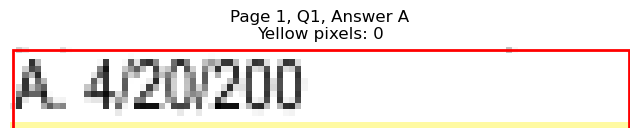

Page 1, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=106.0, y1=127.3
Page 1, Q1, B: Yellow pixels: 1025
Page 1, Q1, B: Total non-white pixels: 1400
Page 1, Q1, B: Yellow percentage: 73.2%


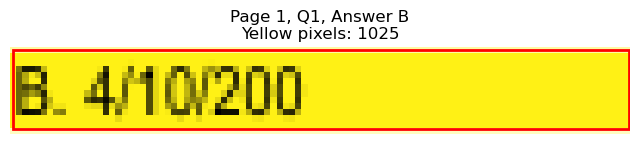

Page 1, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=365.2, y1=114.7
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 235
Page 1, Q1, C: Yellow percentage: 0.0%


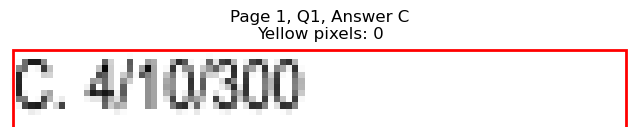

Page 1, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=362.8, y1=127.3
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 237
Page 1, Q1, D: Yellow percentage: 0.0%


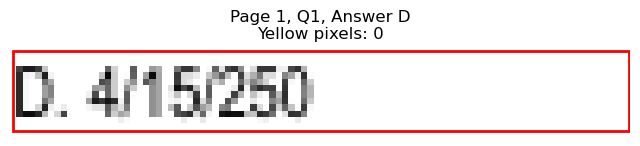


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=107.9, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 337
Page 1, Q2, A: Yellow percentage: 0.0%


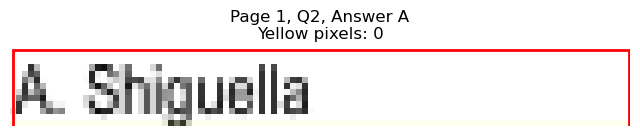

Page 1, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=243.9, y1=215.6
Page 1, Q2, B: Yellow pixels: 2226
Page 1, Q2, B: Total non-white pixels: 3164
Page 1, Q2, B: Yellow percentage: 70.4%


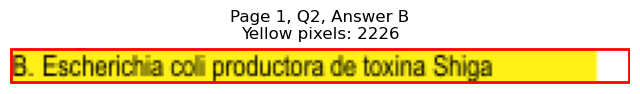

Page 1, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=455.9, y1=203.0
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 681
Page 1, Q2, C: Yellow percentage: 0.0%


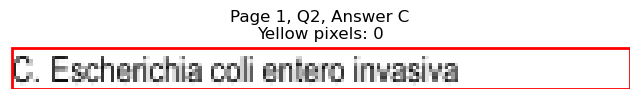

Page 1, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=390.8, y1=215.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 370
Page 1, Q2, D: Yellow percentage: 0.0%


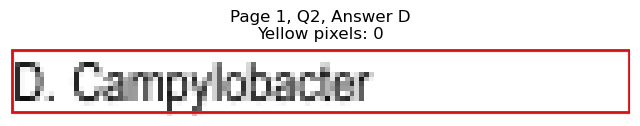


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=185.2, y1=291.4
Page 1, Q3, A: Yellow pixels: 1871
Page 1, Q3, A: Total non-white pixels: 2520
Page 1, Q3, A: Yellow percentage: 74.2%


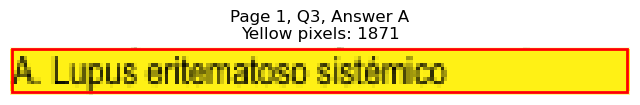

Page 1, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=165.1, y1=304.0
Page 1, Q3, B: Yellow pixels: 160
Page 1, Q3, B: Total non-white pixels: 696
Page 1, Q3, B: Yellow percentage: 23.0%


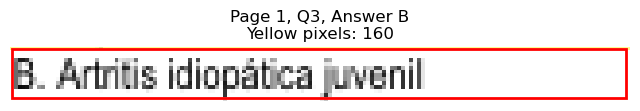

Page 1, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=369.2, y1=291.4
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 227
Page 1, Q3, C: Yellow percentage: 0.0%


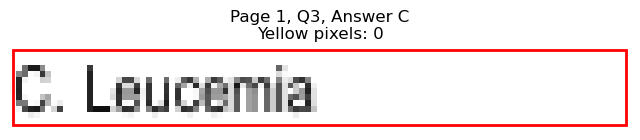

Page 1, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=362.1, y1=304.0
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 186
Page 1, Q3, D: Yellow percentage: 0.0%


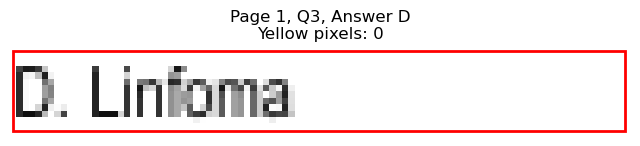


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=219.2, y1=354.6
Page 1, Q4, A: Yellow pixels: 2180
Page 1, Q4, A: Total non-white pixels: 2996
Page 1, Q4, A: Yellow percentage: 72.8%


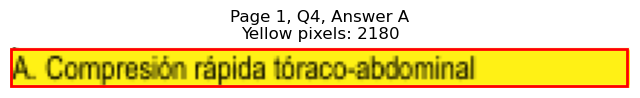

Page 1, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=121.9, y1=367.2
Page 1, Q4, B: Yellow pixels: 116
Page 1, Q4, B: Total non-white pixels: 445
Page 1, Q4, B: Yellow percentage: 26.1%


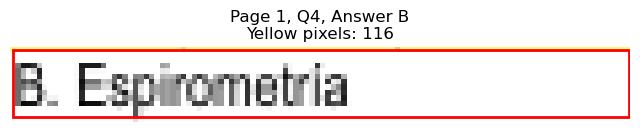

Page 1, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=387.8, y1=354.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 361
Page 1, Q4, C: Yellow percentage: 0.0%


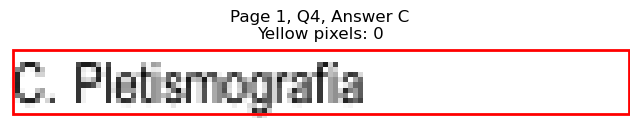

Page 1, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=431.3, y1=367.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 557
Page 1, Q4, D: Yellow percentage: 0.0%


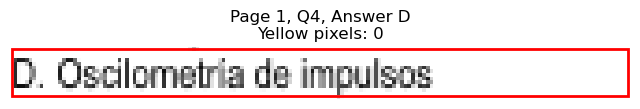


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=115.9, y1=430.3
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 267
Page 1, Q5, A: Yellow percentage: 0.0%


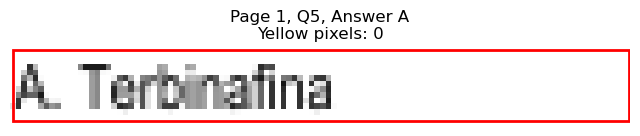

Page 1, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=115.0, y1=442.9
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 257
Page 1, Q5, B: Yellow percentage: 0.0%


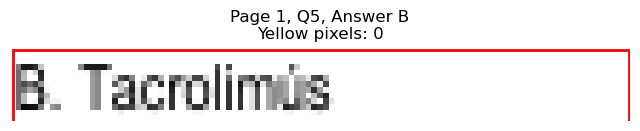

Page 1, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=388.3, y1=430.3
Page 1, Q5, C: Yellow pixels: 124
Page 1, Q5, C: Total non-white pixels: 486
Page 1, Q5, C: Yellow percentage: 25.5%


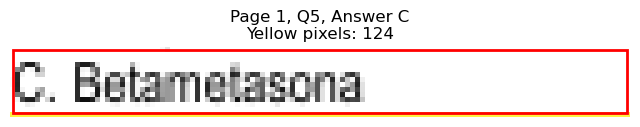

Page 1, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=375.2, y1=442.9
Page 1, Q5, D: Yellow pixels: 1229
Page 1, Q5, D: Total non-white pixels: 1443
Page 1, Q5, D: Yellow percentage: 85.2%


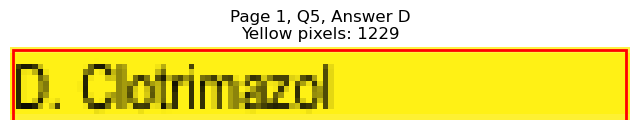


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=119.4, y1=480.7
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 309
Page 1, Q6, A: Yellow percentage: 0.0%


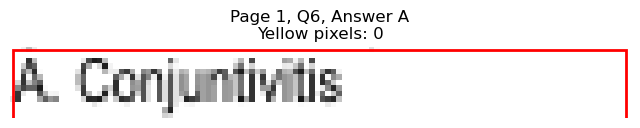

Page 1, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=118.0, y1=493.4
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 310
Page 1, Q6, B: Yellow percentage: 0.0%


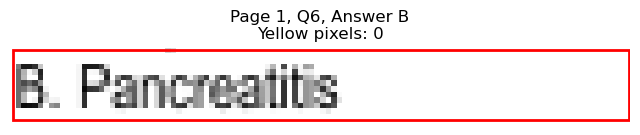

Page 1, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=404.8, y1=480.7
Page 1, Q6, C: Yellow pixels: 1440
Page 1, Q6, C: Total non-white pixels: 1820
Page 1, Q6, C: Yellow percentage: 79.1%


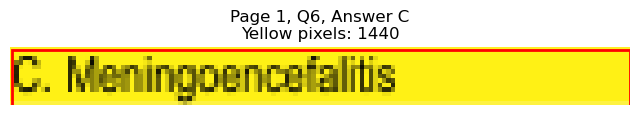

Page 1, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=397.3, y1=493.4
Page 1, Q6, D: Yellow pixels: 132
Page 1, Q6, D: Total non-white pixels: 525
Page 1, Q6, D: Yellow percentage: 25.1%


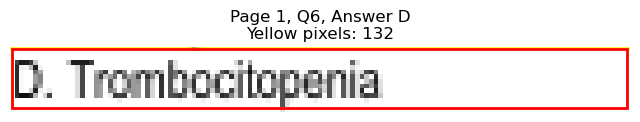


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=151.1, y1=543.8
Page 1, Q7, A: Yellow pixels: 1578
Page 1, Q7, A: Total non-white pixels: 1898
Page 1, Q7, A: Yellow percentage: 83.1%


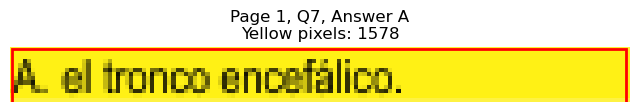

Page 1, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=117.5, y1=556.4
Page 1, Q7, B: Yellow pixels: 112
Page 1, Q7, B: Total non-white pixels: 383
Page 1, Q7, B: Yellow percentage: 29.2%


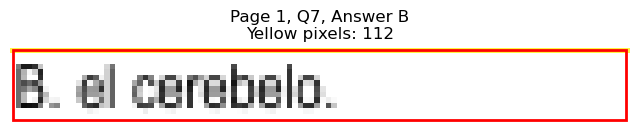

Page 1, Q7 - C: Detected box: x0=315.4, y0=531.2, x1=422.8, y1=543.8
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 508
Page 1, Q7, C: Yellow percentage: 0.0%


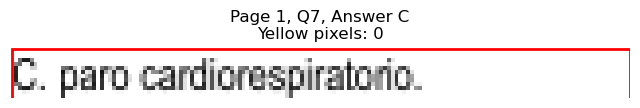

Page 1, Q7 - D: Detected box: x0=315.4, y0=543.8, x1=371.7, y1=556.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 279
Page 1, Q7, D: Yellow percentage: 0.0%


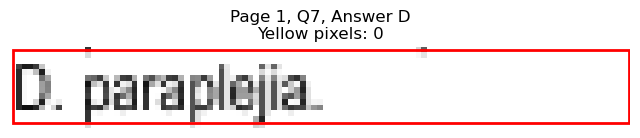


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=102.4, y1=632.3
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 225
Page 1, Q8, A: Yellow percentage: 0.0%


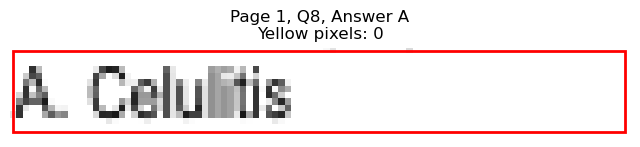

Page 1, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=143.1, y1=644.9
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 411
Page 1, Q8, B: Yellow percentage: 0.0%


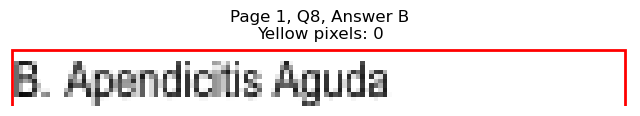

Page 1, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=378.3, y1=632.3
Page 1, Q8, C: Yellow pixels: 114
Page 1, Q8, C: Total non-white pixels: 419
Page 1, Q8, C: Yellow percentage: 27.2%


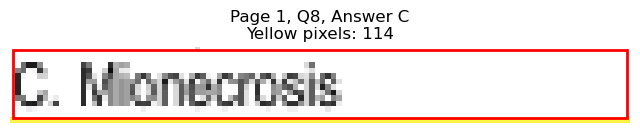

Page 1, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=407.8, y1=644.9
Page 1, Q8, D: Yellow pixels: 1526
Page 1, Q8, D: Total non-white pixels: 1859
Page 1, Q8, D: Yellow percentage: 82.1%


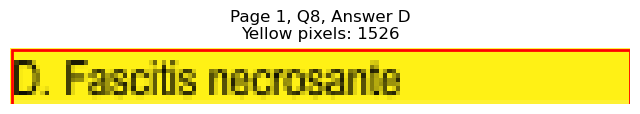


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=168.1, y1=708.0
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 575
Page 1, Q9, A: Yellow percentage: 0.0%


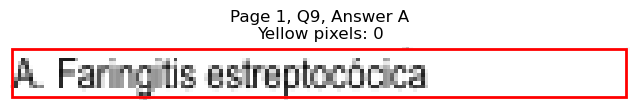

Page 1, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=173.7, y1=720.6
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 609
Page 1, Q9, B: Yellow percentage: 0.0%


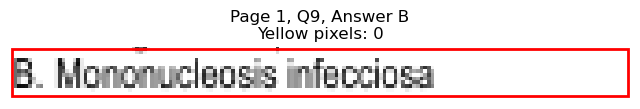

Page 1, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=406.3, y1=708.0
Page 1, Q9, C: Yellow pixels: 142
Page 1, Q9, C: Total non-white pixels: 742
Page 1, Q9, C: Yellow percentage: 19.1%


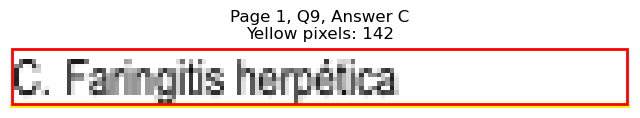

Page 1, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=376.7, y1=720.6
Page 1, Q9, D: Yellow pixels: 1205
Page 1, Q9, D: Total non-white pixels: 1568
Page 1, Q9, D: Yellow percentage: 76.8%


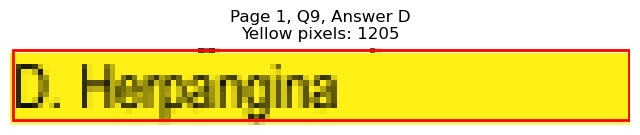


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=745.8, x1=146.5, y1=758.4
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 471
Page 1, Q10, A: Yellow percentage: 0.0%


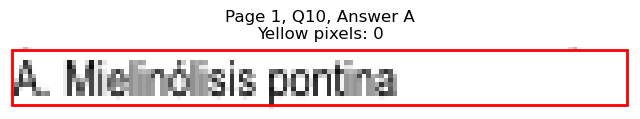

Page 1, Q10 - B: Detected box: x0=56.6, y0=758.5, x1=152.1, y1=771.1
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 471
Page 1, Q10, B: Yellow percentage: 0.0%


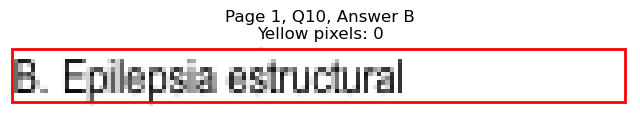

Page 1, Q10 - C: Detected box: x0=315.4, y0=745.8, x1=412.4, y1=758.4
Page 1, Q10, C: Yellow pixels: 1569
Page 1, Q10, C: Total non-white pixels: 2072
Page 1, Q10, C: Yellow percentage: 75.7%


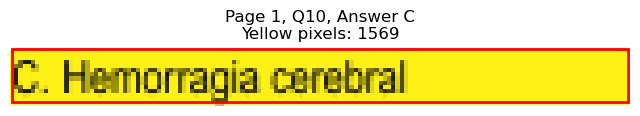

Page 1, Q10 - D: Detected box: x0=315.4, y0=758.5, x1=428.9, y1=771.1
Page 1, Q10, D: Yellow pixels: 162
Page 1, Q10, D: Total non-white pixels: 750
Page 1, Q10, D: Yellow percentage: 21.6%


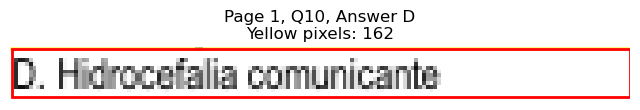


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)

Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=306.6, y1=114.7
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 1219
Page 2, Q1, A: Yellow percentage: 0.0%


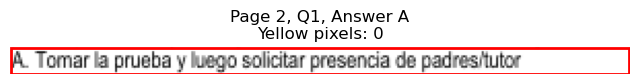

Page 2, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=302.0, y1=127.3
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 1196
Page 2, Q1, B: Yellow percentage: 0.0%


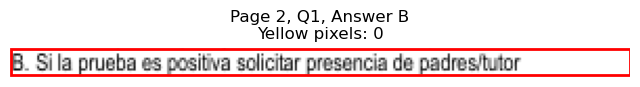

Page 2, Q1 - C: Detected box: x0=56.6, y0=127.2, x1=241.8, y1=139.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 917
Page 2, Q1, C: Yellow percentage: 0.0%


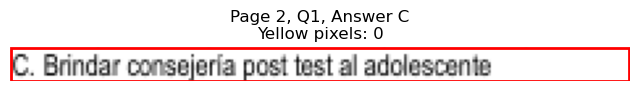

Page 2, Q1 - D: Detected box: x0=56.6, y0=139.9, x1=282.9, y1=152.6
Page 2, Q1, D: Yellow pixels: 2745
Page 2, Q1, D: Total non-white pixels: 3878
Page 2, Q1, D: Yellow percentage: 70.8%


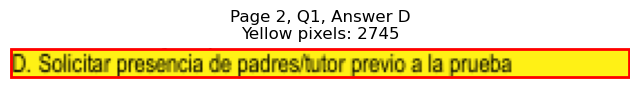


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=122.9, y1=203.0
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 420
Page 2, Q2, A: Yellow percentage: 0.0%


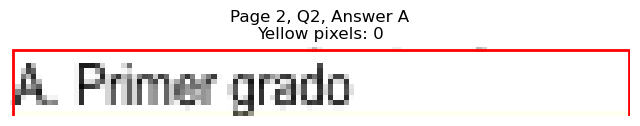

Page 2, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=132.5, y1=215.6
Page 2, Q2, B: Yellow pixels: 1349
Page 2, Q2, B: Total non-white pixels: 1778
Page 2, Q2, B: Yellow percentage: 75.9%


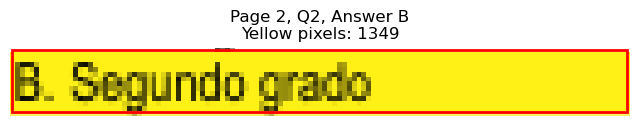

Page 2, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=381.7, y1=203.0
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 296
Page 2, Q2, C: Yellow percentage: 0.0%


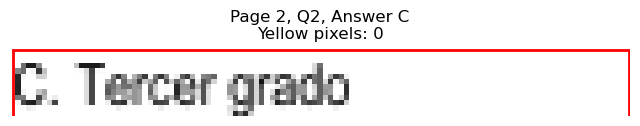

Page 2, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=387.8, y1=215.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 360
Page 2, Q2, D: Yellow percentage: 0.0%


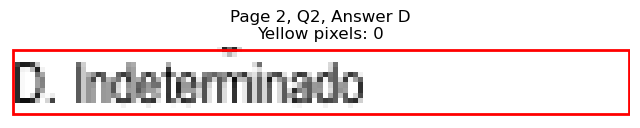


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=132.0, y1=253.5
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 371
Page 2, Q3, A: Yellow percentage: 0.0%


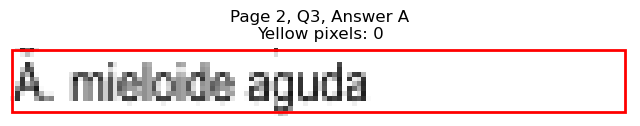

Page 2, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=136.0, y1=266.1
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 401
Page 2, Q3, B: Yellow percentage: 0.0%


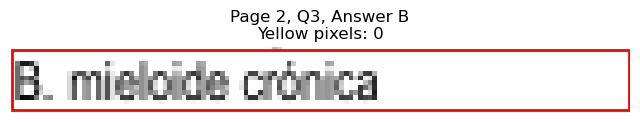

Page 2, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=404.8, y1=253.5
Page 2, Q3, C: Yellow pixels: 1457
Page 2, Q3, C: Total non-white pixels: 1960
Page 2, Q3, C: Yellow percentage: 74.3%


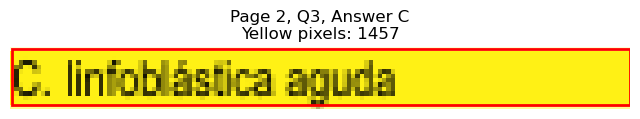

Page 2, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=412.9, y1=266.1
Page 2, Q3, D: Yellow pixels: 147
Page 2, Q3, D: Total non-white pixels: 640
Page 2, Q3, D: Yellow percentage: 23.0%


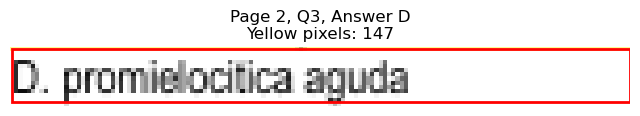


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=119.9, y1=316.6
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 299
Page 2, Q4, A: Yellow percentage: 0.0%


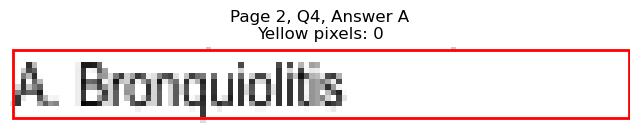

Page 2, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=165.6, y1=329.2
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 566
Page 2, Q4, B: Yellow percentage: 0.0%


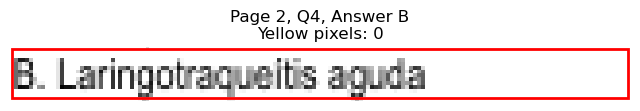

Page 2, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=444.9, y1=316.6
Page 2, Q4, C: Yellow pixels: 1878
Page 2, Q4, C: Total non-white pixels: 2350
Page 2, Q4, C: Yellow percentage: 79.9%


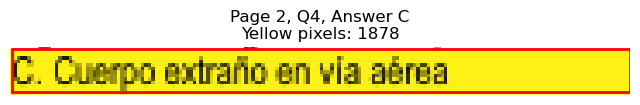

Page 2, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=391.3, y1=329.2
Page 2, Q4, D: Yellow pixels: 127
Page 2, Q4, D: Total non-white pixels: 497
Page 2, Q4, D: Yellow percentage: 25.6%


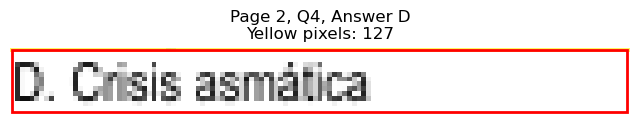


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=164.7, y1=367.2
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 510
Page 2, Q5, A: Yellow percentage: 0.0%


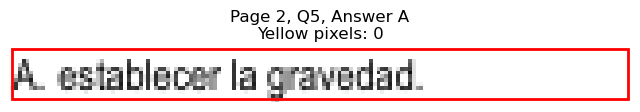

Page 2, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=217.4, y1=379.8
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 758
Page 2, Q5, B: Yellow percentage: 0.0%


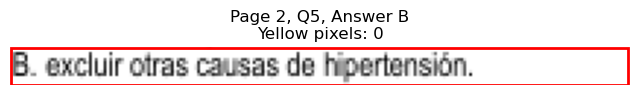

Page 2, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=476.0, y1=367.2
Page 2, Q5, C: Yellow pixels: 2162
Page 2, Q5, C: Total non-white pixels: 2968
Page 2, Q5, C: Yellow percentage: 72.8%


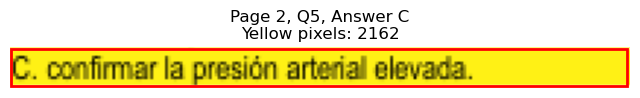

Page 2, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=511.2, y1=379.8
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 1201
Page 2, Q5, D: Yellow percentage: 0.0%


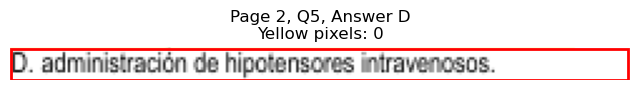


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=115.9, y1=455.5
Page 2, Q6, A: Yellow pixels: 110
Page 2, Q6, A: Total non-white pixels: 387
Page 2, Q6, A: Yellow percentage: 28.4%


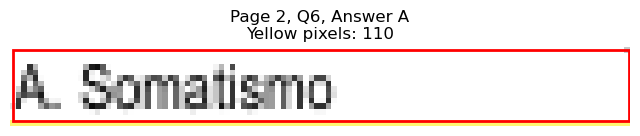

Page 2, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=111.4, y1=468.1
Page 2, Q6, B: Yellow pixels: 1164
Page 2, Q6, B: Total non-white pixels: 1484
Page 2, Q6, B: Yellow percentage: 78.4%


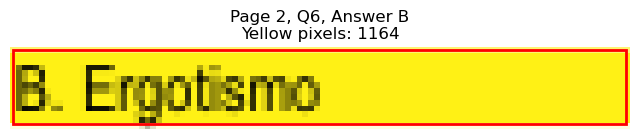

Page 2, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=384.7, y1=455.5
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 339
Page 2, Q6, C: Yellow percentage: 0.0%


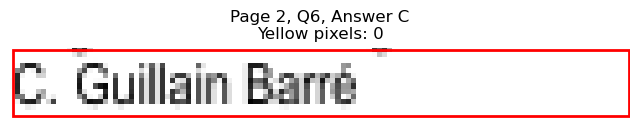

Page 2, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=402.3, y1=468.1
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 449
Page 2, Q6, D: Yellow percentage: 0.0%


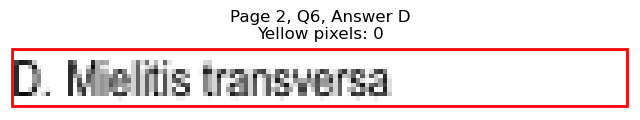


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=107.9, y1=506.0
Page 2, Q7, A: Yellow pixels: 102
Page 2, Q7, A: Total non-white pixels: 452
Page 2, Q7, A: Yellow percentage: 22.6%


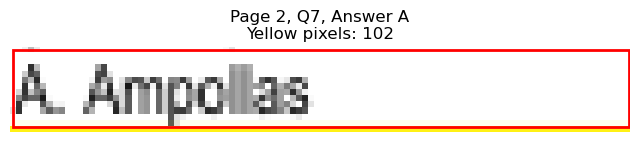

Page 2, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=182.7, y1=518.6
Page 2, Q7, B: Yellow pixels: 1816
Page 2, Q7, B: Total non-white pixels: 2478
Page 2, Q7, B: Yellow percentage: 73.3%


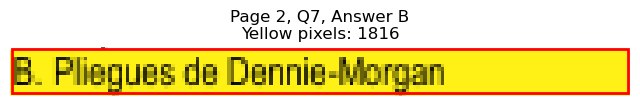

Page 2, Q7 - C: Detected box: x0=315.4, y0=493.4, x1=428.8, y1=506.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 539
Page 2, Q7, C: Yellow percentage: 0.0%


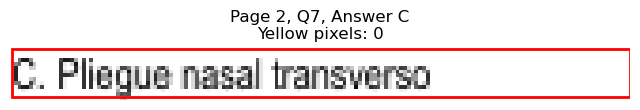

Page 2, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=393.2, y1=518.6
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 390
Page 2, Q7, D: Yellow percentage: 0.0%


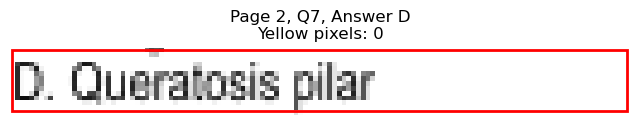


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=176.7, y1=581.7
Page 2, Q8, A: Yellow pixels: 1766
Page 2, Q8, A: Total non-white pixels: 2223
Page 2, Q8, A: Yellow percentage: 79.4%


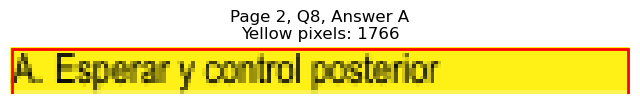

Page 2, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=195.7, y1=594.3
Page 2, Q8, B: Yellow pixels: 189
Page 2, Q8, B: Total non-white pixels: 883
Page 2, Q8, B: Yellow percentage: 21.4%


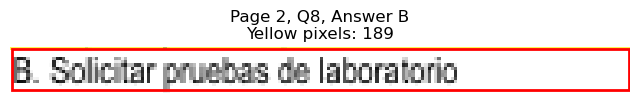

Page 2, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=452.5, y1=581.7
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 684
Page 2, Q8, C: Yellow percentage: 0.0%


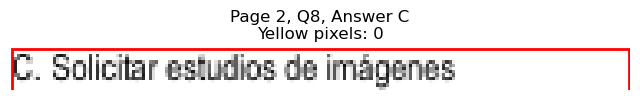

Page 2, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=445.4, y1=594.3
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 656
Page 2, Q8, D: Yellow percentage: 0.0%


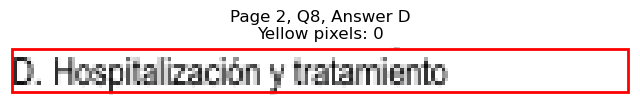


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=226.2, y1=657.5
Page 2, Q9, A: Yellow pixels: 221
Page 2, Q9, A: Total non-white pixels: 1062
Page 2, Q9, A: Yellow percentage: 20.8%


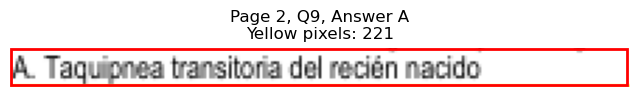

Page 2, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=208.2, y1=670.1
Page 2, Q9, B: Yellow pixels: 2052
Page 2, Q9, B: Total non-white pixels: 2842
Page 2, Q9, B: Yellow percentage: 72.2%


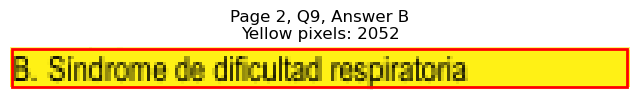

Page 2, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=408.8, y1=657.5
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 464
Page 2, Q9, C: Yellow percentage: 0.0%


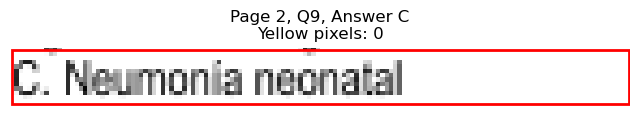

Page 2, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=431.9, y1=670.1
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 597
Page 2, Q9, D: Yellow percentage: 0.0%


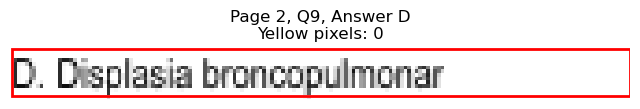


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)

Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=152.5, x1=170.1, y1=165.2
Page 3, Q1, A: Yellow pixels: 1724
Page 3, Q1, A: Total non-white pixels: 2310
Page 3, Q1, A: Yellow percentage: 74.6%


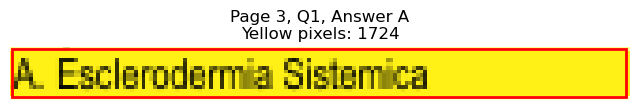

Page 3, Q1 - B: Detected box: x0=56.6, y0=165.1, x1=145.0, y1=177.8
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 565
Page 3, Q1, B: Yellow percentage: 0.0%


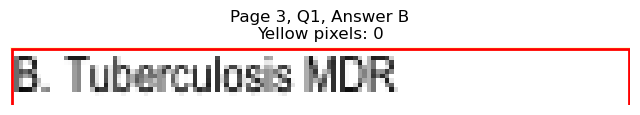

Page 3, Q1 - C: Detected box: x0=315.4, y0=152.5, x1=412.3, y1=165.2
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 454
Page 3, Q1, C: Yellow percentage: 0.0%


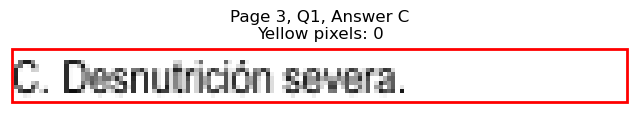

Page 3, Q1 - D: Detected box: x0=315.4, y0=165.1, x1=427.3, y1=177.8
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 580
Page 3, Q1, D: Yellow percentage: 0.0%


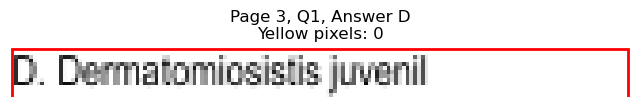


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=106.9, y1=215.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 267
Page 3, Q2, A: Yellow percentage: 0.0%


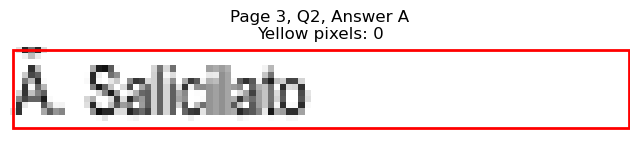

Page 3, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=115.5, y1=228.3
Page 3, Q2, B: Yellow pixels: 1082
Page 3, Q2, B: Total non-white pixels: 1540
Page 3, Q2, B: Yellow percentage: 70.3%


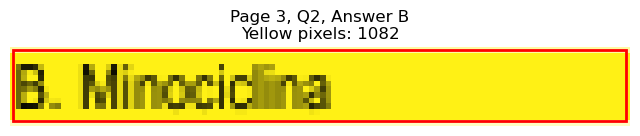

Page 3, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=377.7, y1=215.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 293
Page 3, Q2, C: Yellow percentage: 0.0%


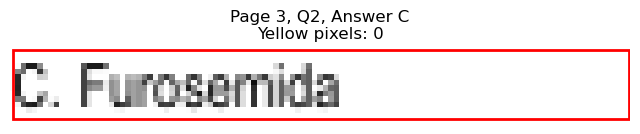

Page 3, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=373.7, y1=228.3
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 269
Page 3, Q2, D: Yellow percentage: 0.0%


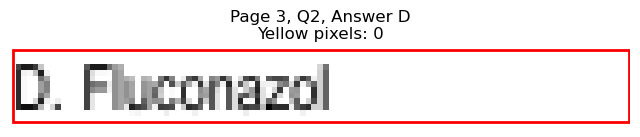


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=291.4, x1=177.1, y1=304.0
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 574
Page 3, Q3, A: Yellow percentage: 0.0%


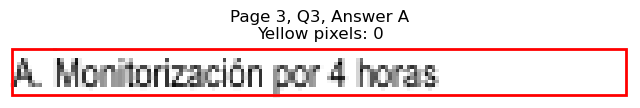

Page 3, Q3 - B: Detected box: x0=56.6, y0=304.0, x1=154.2, y1=316.6
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 472
Page 3, Q3, B: Yellow percentage: 0.0%


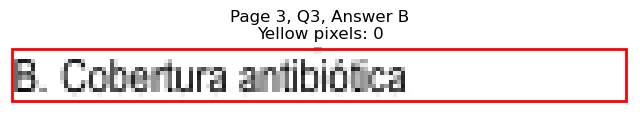

Page 3, Q3 - C: Detected box: x0=315.4, y0=291.4, x1=450.9, y1=304.0
Page 3, Q3, C: Yellow pixels: 186
Page 3, Q3, C: Total non-white pixels: 832
Page 3, Q3, C: Yellow percentage: 22.4%


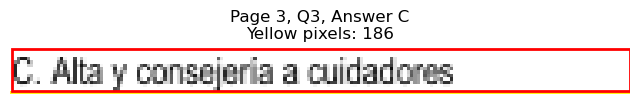

Page 3, Q3 - D: Detected box: x0=315.4, y0=304.0, x1=429.3, y1=316.6
Page 3, Q3, D: Yellow pixels: 1721
Page 3, Q3, D: Total non-white pixels: 2149
Page 3, Q3, D: Yellow percentage: 80.1%


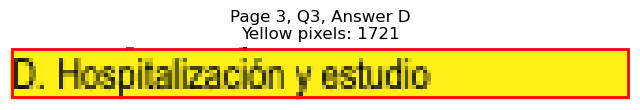


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=379.7, x1=135.5, y1=392.4
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 399
Page 3, Q4, A: Yellow percentage: 0.0%


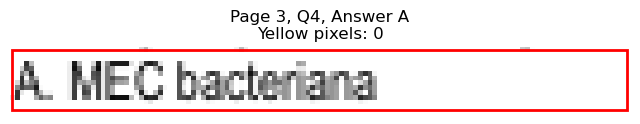

Page 3, Q4 - B: Detected box: x0=56.6, y0=392.3, x1=109.9, y1=405.0
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 234
Page 3, Q4, B: Yellow percentage: 0.0%


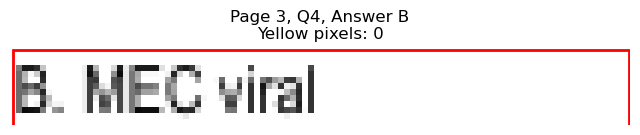

Page 3, Q4 - C: Detected box: x0=315.4, y0=379.7, x1=364.1, y1=392.4
Page 3, Q4, C: Yellow pixels: 1029
Page 3, Q4, C: Total non-white pixels: 1400
Page 3, Q4, C: Yellow percentage: 73.5%


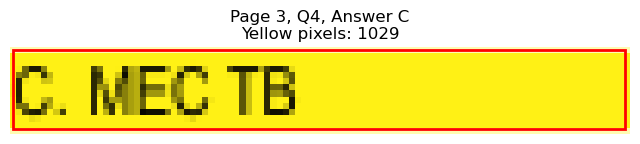

Page 3, Q4 - D: Detected box: x0=315.4, y0=392.3, x1=418.3, y1=405.0
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 687
Page 3, Q4, D: Yellow percentage: 0.0%


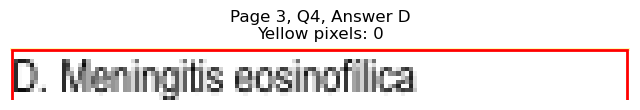


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=455.5, x1=138.5, y1=468.1
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 378
Page 3, Q5, A: Yellow percentage: 0.0%


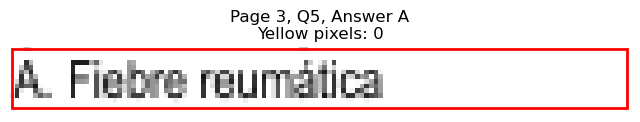

Page 3, Q5 - B: Detected box: x0=56.6, y0=468.1, x1=165.1, y1=480.7
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 536
Page 3, Q5, B: Yellow percentage: 0.0%


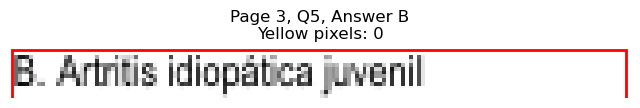

Page 3, Q5 - C: Detected box: x0=315.4, y0=455.5, x1=444.4, y1=468.1
Page 3, Q5, C: Yellow pixels: 180
Page 3, Q5, C: Total non-white pixels: 795
Page 3, Q5, C: Yellow percentage: 22.6%


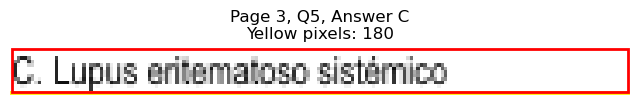

Page 3, Q5 - D: Detected box: x0=315.4, y0=468.1, x1=432.9, y1=480.7
Page 3, Q5, D: Yellow pixels: 1732
Page 3, Q5, D: Total non-white pixels: 2184
Page 3, Q5, D: Yellow percentage: 79.3%


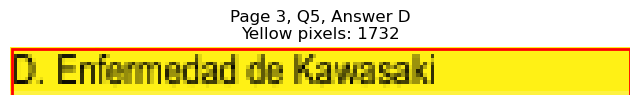


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=518.6, x1=148.6, y1=531.2
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 480
Page 3, Q6, A: Yellow percentage: 0.0%


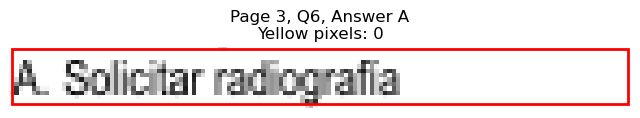

Page 3, Q6 - B: Detected box: x0=56.6, y0=531.2, x1=166.1, y1=543.8
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 519
Page 3, Q6, B: Yellow percentage: 0.0%


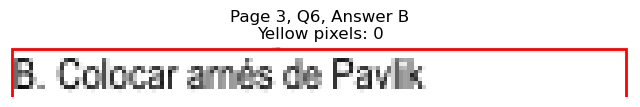

Page 3, Q6 - C: Detected box: x0=315.4, y0=518.6, x1=402.4, y1=531.2
Page 3, Q6, C: Yellow pixels: 1482
Page 3, Q6, C: Total non-white pixels: 1932
Page 3, Q6, C: Yellow percentage: 76.7%


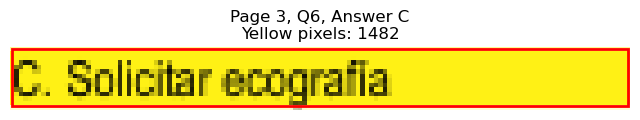

Page 3, Q6 - D: Detected box: x0=315.4, y0=531.2, x1=407.8, y1=543.8
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 600
Page 3, Q6, D: Yellow percentage: 0.0%


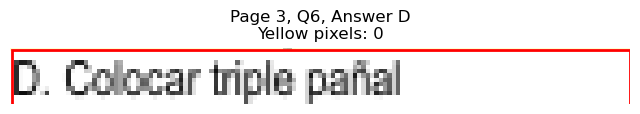


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=594.3, x1=127.9, y1=606.9
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 348
Page 3, Q7, A: Yellow percentage: 0.0%


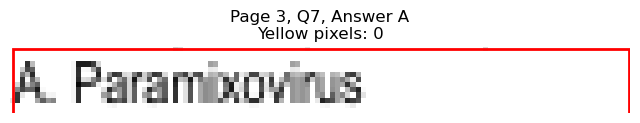

Page 3, Q7 - B: Detected box: x0=56.6, y0=606.9, x1=129.0, y1=619.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 325
Page 3, Q7, B: Yellow percentage: 0.0%


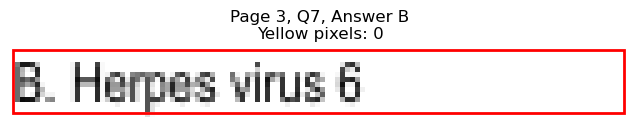

Page 3, Q7 - C: Detected box: x0=315.4, y0=594.3, x1=387.2, y1=606.9
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 448
Page 3, Q7, C: Yellow percentage: 0.0%


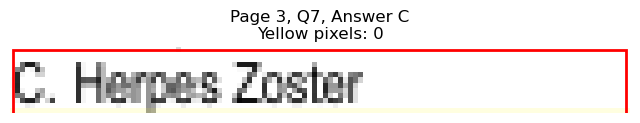

Page 3, Q7 - D: Detected box: x0=315.4, y0=606.9, x1=391.3, y1=619.5
Page 3, Q7, D: Yellow pixels: 1396
Page 3, Q7, D: Total non-white pixels: 1778
Page 3, Q7, D: Yellow percentage: 78.5%


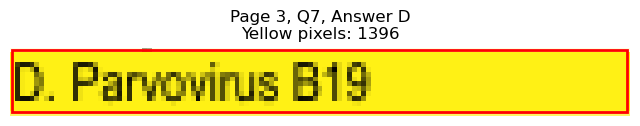


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=670.0, x1=101.9, y1=682.7
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 192
Page 3, Q8, A: Yellow percentage: 0.0%


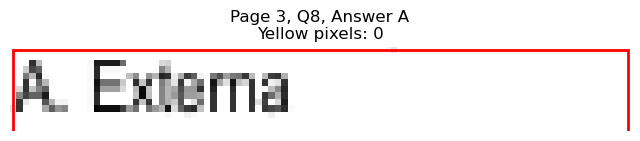

Page 3, Q8 - B: Detected box: x0=56.6, y0=682.6, x1=127.0, y1=695.3
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 357
Page 3, Q8, B: Yellow percentage: 0.0%


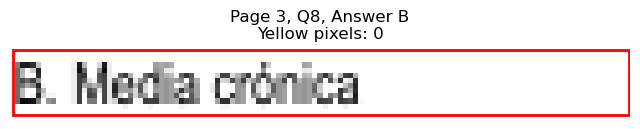

Page 3, Q8 - C: Detected box: x0=315.4, y0=670.0, x1=358.1, y1=682.7
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 289
Page 3, Q8, C: Yellow percentage: 0.0%


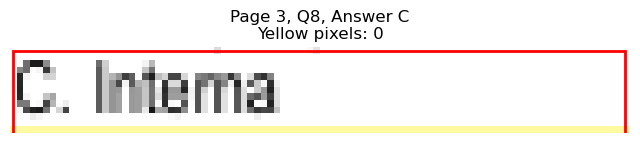

Page 3, Q8 - D: Detected box: x0=315.4, y0=682.6, x1=382.3, y1=695.3
Page 3, Q8, D: Yellow pixels: 1166
Page 3, Q8, D: Total non-white pixels: 1652
Page 3, Q8, D: Yellow percentage: 70.6%


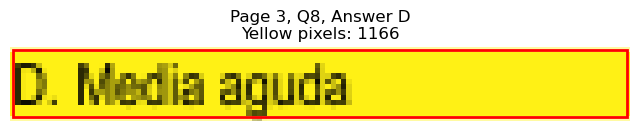


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)

Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=308.6, y1=114.7
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 1240
Page 4, Q1, A: Yellow percentage: 0.0%


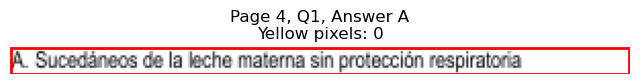

Page 4, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=272.9, y1=127.3
Page 4, Q1, B: Yellow pixels: 267
Page 4, Q1, B: Total non-white pixels: 1306
Page 4, Q1, B: Yellow percentage: 20.4%


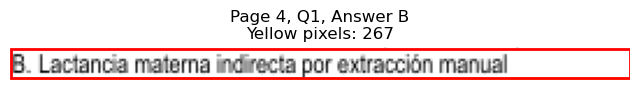

Page 4, Q1 - C: Detected box: x0=56.6, y0=127.2, x1=294.0, y1=139.9
Page 4, Q1, C: Yellow pixels: 2864
Page 4, Q1, C: Total non-white pixels: 3757
Page 4, Q1, C: Yellow percentage: 76.2%


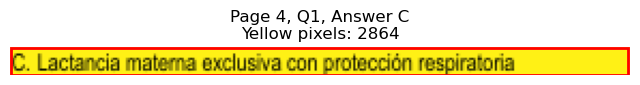

Page 4, Q1 - D: Detected box: x0=56.6, y0=139.9, x1=224.7, y1=152.6
Page 4, Q1, D: Yellow pixels: 216
Page 4, Q1, D: Total non-white pixels: 1048
Page 4, Q1, D: Yellow percentage: 20.6%


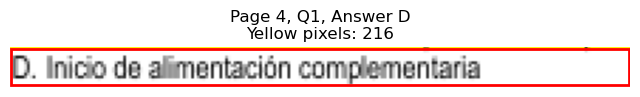


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=215.6, x1=175.1, y1=228.3
Page 4, Q2, A: Yellow pixels: 1610
Page 4, Q2, A: Total non-white pixels: 2380
Page 4, Q2, A: Yellow percentage: 67.6%


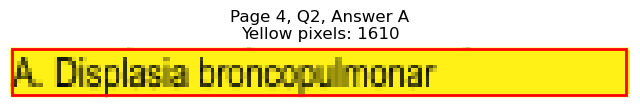

Page 4, Q2 - B: Detected box: x0=56.6, y0=228.2, x1=127.5, y1=240.9
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 469
Page 4, Q2, B: Yellow percentage: 0.0%


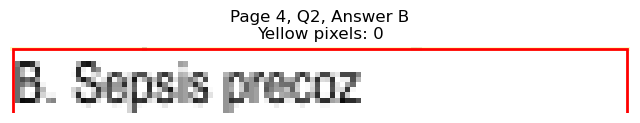

Page 4, Q2 - C: Detected box: x0=315.4, y0=215.6, x1=465.9, y1=228.3
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 704
Page 4, Q2, C: Yellow percentage: 0.0%


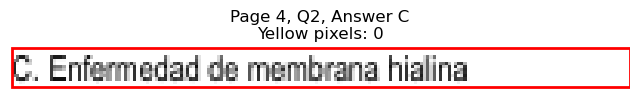

Page 4, Q2 - D: Detected box: x0=315.4, y0=228.2, x1=408.8, y1=240.9
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 454
Page 4, Q2, D: Yellow percentage: 0.0%


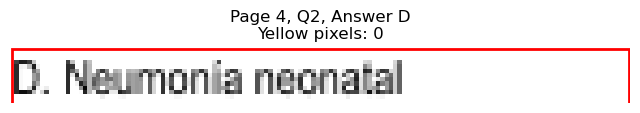


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=158.5, y1=291.4
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 491
Page 4, Q3, A: Yellow percentage: 0.0%


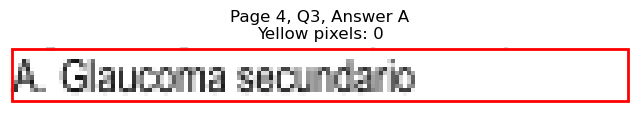

Page 4, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=133.5, y1=304.0
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 380
Page 4, Q3, B: Yellow percentage: 0.0%


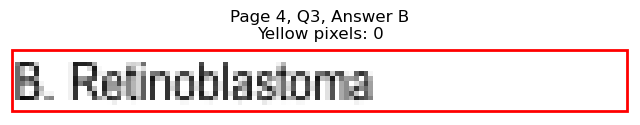

Page 4, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=409.3, y1=291.4
Page 4, Q3, C: Yellow pixels: 145
Page 4, Q3, C: Total non-white pixels: 610
Page 4, Q3, C: Yellow percentage: 23.8%


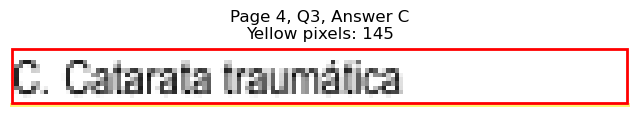

Page 4, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=435.9, y1=304.0
Page 4, Q3, D: Yellow pixels: 1770
Page 4, Q3, D: Total non-white pixels: 2394
Page 4, Q3, D: Yellow percentage: 73.9%


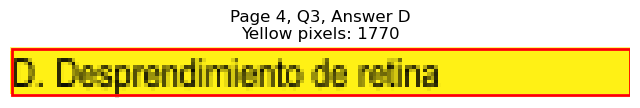


Page 4, Q3 - Selected Answer: D (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=104.4, y1=354.6
Page 4, Q4, A: Yellow pixels: 1144
Page 4, Q4, A: Total non-white pixels: 1386
Page 4, Q4, A: Yellow percentage: 82.5%


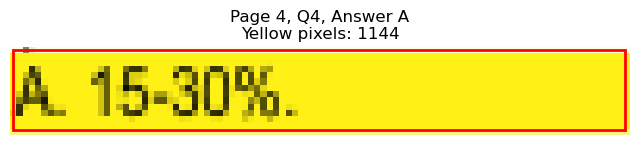

Page 4, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=104.4, y1=367.2
Page 4, Q4, B: Yellow pixels: 99
Page 4, Q4, B: Total non-white pixels: 323
Page 4, Q4, B: Yellow percentage: 30.7%


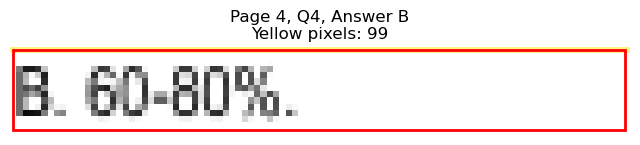

Page 4, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=363.7, y1=354.6
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 213
Page 4, Q4, C: Yellow percentage: 0.0%


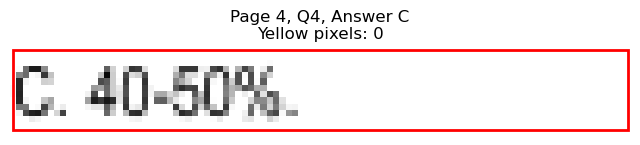

Page 4, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=350.8, y1=367.2
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 139
Page 4, Q4, D: Yellow percentage: 0.0%


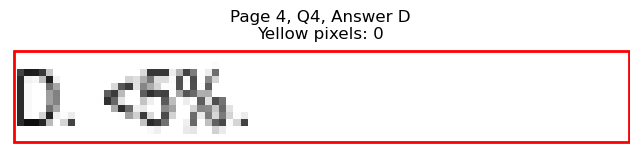


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=77.3, y1=430.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 68
Page 4, Q5, A: Yellow percentage: 0.0%


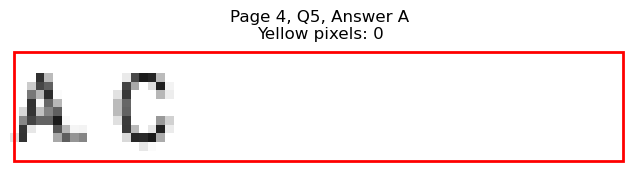

Page 4, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=86.9, y1=442.9
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 128
Page 4, Q5, B: Yellow percentage: 0.0%


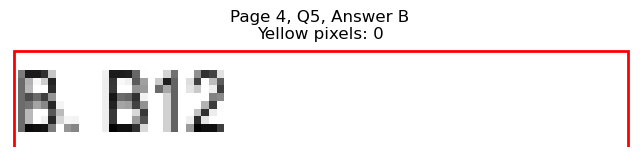

Page 4, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=341.1, y1=430.3
Page 4, Q5, C: Yellow pixels: 77
Page 4, Q5, C: Total non-white pixels: 186
Page 4, Q5, C: Yellow percentage: 41.4%


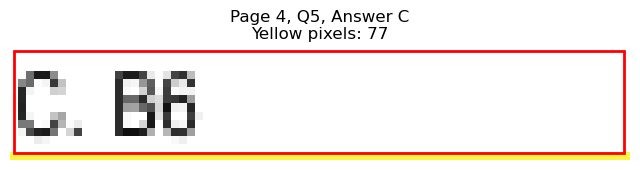

Page 4, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=336.1, y1=442.9
Page 4, Q5, D: Yellow pixels: 881
Page 4, Q5, D: Total non-white pixels: 936
Page 4, Q5, D: Yellow percentage: 94.1%


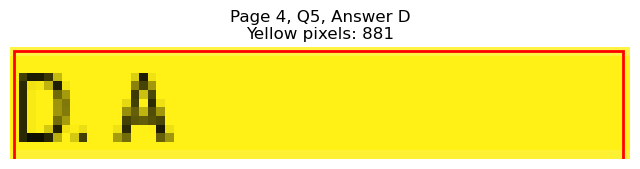


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=506.0, x1=189.6, y1=518.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 633
Page 4, Q6, A: Yellow percentage: 0.0%


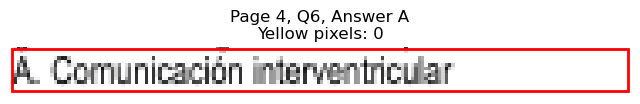

Page 4, Q6 - B: Detected box: x0=56.6, y0=518.6, x1=150.0, y1=531.2
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 447
Page 4, Q6, B: Yellow percentage: 0.0%


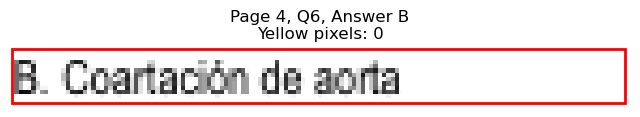

Page 4, Q6 - C: Detected box: x0=315.4, y0=506.0, x1=441.9, y1=518.6
Page 4, Q6, C: Yellow pixels: 1857
Page 4, Q6, C: Total non-white pixels: 2478
Page 4, Q6, C: Yellow percentage: 74.9%


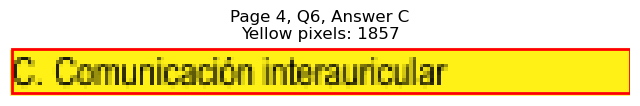

Page 4, Q6 - D: Detected box: x0=315.4, y0=518.6, x1=395.7, y1=531.2
Page 4, Q6, D: Yellow pixels: 131
Page 4, Q6, D: Total non-white pixels: 513
Page 4, Q6, D: Yellow percentage: 25.5%


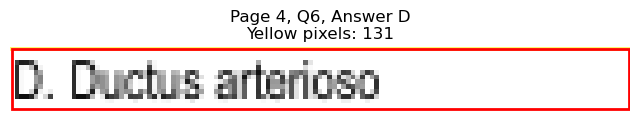


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=569.1, x1=75.9, y1=581.7
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 142
Page 4, Q7, A: Yellow percentage: 0.0%


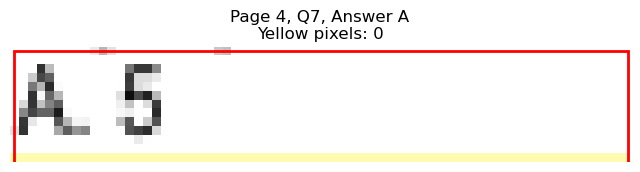

Page 4, Q7 - B: Detected box: x0=56.6, y0=581.7, x1=75.9, y1=594.3
Page 4, Q7, B: Yellow pixels: 776
Page 4, Q7, B: Total non-white pixels: 980
Page 4, Q7, B: Yellow percentage: 79.2%


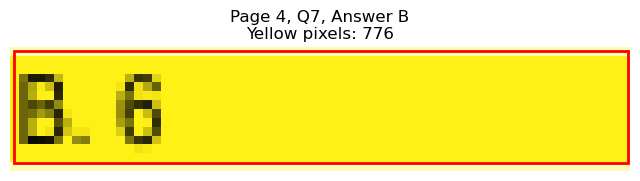

Page 4, Q7 - C: Detected box: x0=315.4, y0=569.1, x1=340.1, y1=581.7
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 62
Page 4, Q7, C: Yellow percentage: 0.0%


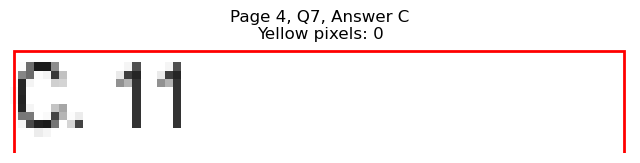

Page 4, Q7 - D: Detected box: x0=315.4, y0=581.7, x1=340.1, y1=594.3
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 79
Page 4, Q7, D: Yellow percentage: 0.0%


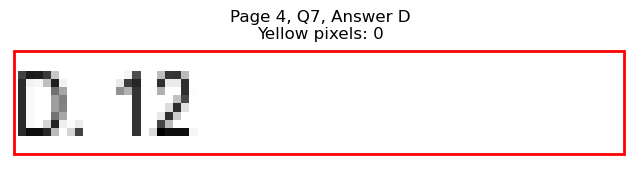


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=657.4, x1=137.1, y1=670.1
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 390
Page 4, Q8, A: Yellow percentage: 0.0%


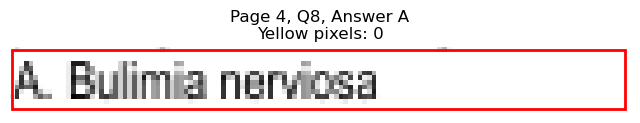

Page 4, Q8 - B: Detected box: x0=56.6, y0=670.0, x1=163.1, y1=682.7
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 491
Page 4, Q8, B: Yellow percentage: 0.0%


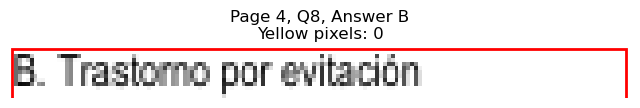

Page 4, Q8 - C: Detected box: x0=315.4, y0=657.4, x1=402.3, y1=670.1
Page 4, Q8, C: Yellow pixels: 1499
Page 4, Q8, C: Total non-white pixels: 1932
Page 4, Q8, C: Yellow percentage: 77.6%


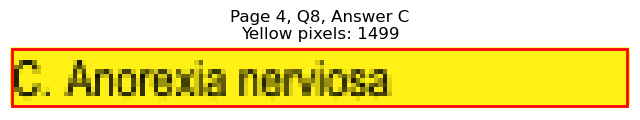

Page 4, Q8 - D: Detected box: x0=315.4, y0=670.0, x1=400.7, y1=682.7
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 555
Page 4, Q8, D: Yellow percentage: 0.0%


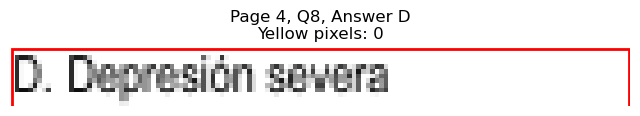


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=733.2, x1=161.5, y1=745.8
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 648
Page 4, Q9, A: Yellow percentage: 0.0%


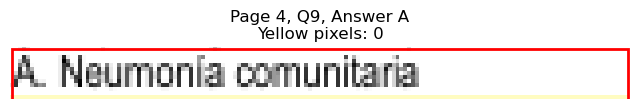

Page 4, Q9 - B: Detected box: x0=56.6, y0=745.8, x1=157.1, y1=758.4
Page 4, Q9, B: Yellow pixels: 1592
Page 4, Q9, B: Total non-white pixels: 2128
Page 4, Q9, B: Yellow percentage: 74.8%


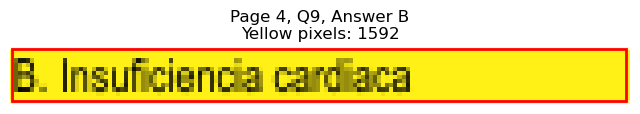

Page 4, Q9 - C: Detected box: x0=315.4, y0=733.2, x1=414.8, y1=745.8
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 506
Page 4, Q9, C: Yellow percentage: 0.0%


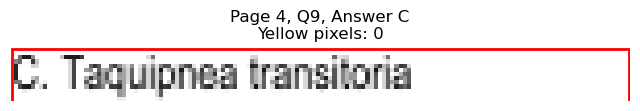

Page 4, Q9 - D: Detected box: x0=315.4, y0=745.8, x1=394.3, y1=758.4
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 391
Page 4, Q9, D: Yellow percentage: 0.0%


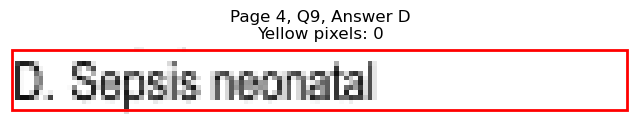


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)

Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=132.0, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 359
Page 5, Q1, A: Yellow percentage: 0.0%


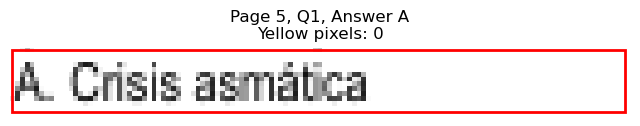

Page 5, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=115.1, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 285
Page 5, Q1, B: Yellow percentage: 0.0%


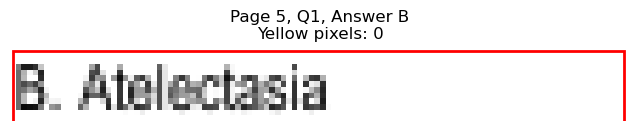

Page 5, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=400.7, y1=127.3
Page 5, Q1, C: Yellow pixels: 1315
Page 5, Q1, C: Total non-white pixels: 1904
Page 5, Q1, C: Yellow percentage: 69.1%


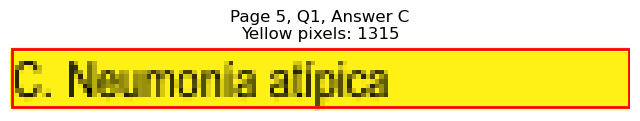

Page 5, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=397.7, y1=139.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 536
Page 5, Q1, D: Yellow percentage: 0.0%


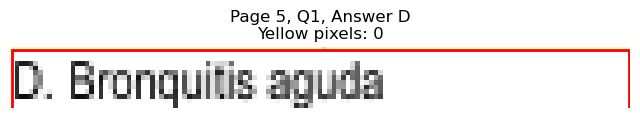


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=109.9, y1=190.4
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 235
Page 5, Q2, A: Yellow percentage: 0.0%


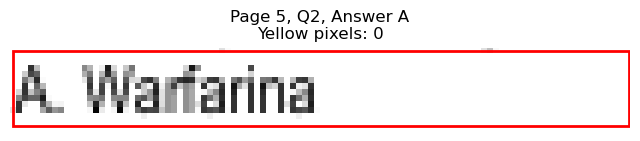

Page 5, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=121.5, y1=203.0
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 316
Page 5, Q2, B: Yellow percentage: 0.0%


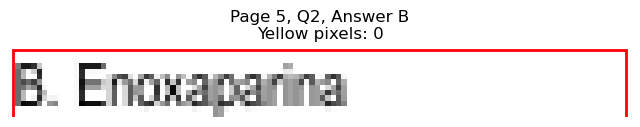

Page 5, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=428.3, y1=190.4
Page 5, Q2, C: Yellow pixels: 1564
Page 5, Q2, C: Total non-white pixels: 2296
Page 5, Q2, C: Yellow percentage: 68.1%


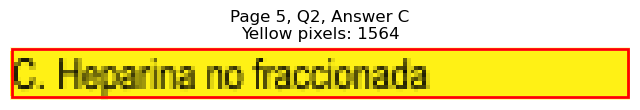

Page 5, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=373.7, y1=203.0
Page 5, Q2, D: Yellow pixels: 1
Page 5, Q2, D: Total non-white pixels: 371
Page 5, Q2, D: Yellow percentage: 0.3%


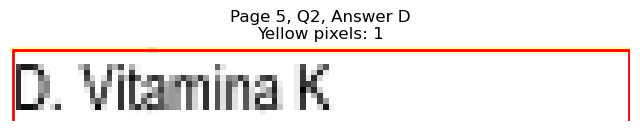


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=171.6, y1=266.1
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 591
Page 5, Q3, A: Yellow percentage: 0.0%


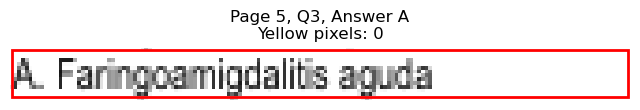

Page 5, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=138.0, y1=278.7
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 397
Page 5, Q3, B: Yellow percentage: 0.0%


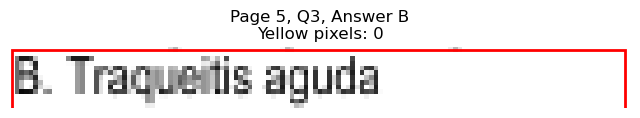

Page 5, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=430.4, y1=266.1
Page 5, Q3, C: Yellow pixels: 166
Page 5, Q3, C: Total non-white pixels: 738
Page 5, Q3, C: Yellow percentage: 22.5%


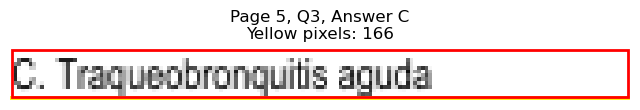

Page 5, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=393.8, y1=278.7
Page 5, Q3, D: Yellow pixels: 1387
Page 5, Q3, D: Total non-white pixels: 1677
Page 5, Q3, D: Yellow percentage: 82.7%


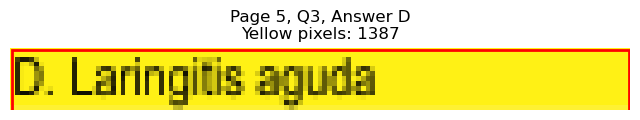


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=161.5, y1=354.6
Page 5, Q4, A: Yellow pixels: 156
Page 5, Q4, A: Total non-white pixels: 656
Page 5, Q4, A: Yellow percentage: 23.8%


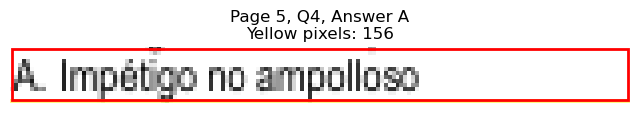

Page 5, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=102.4, y1=367.2
Page 5, Q4, B: Yellow pixels: 1082
Page 5, Q4, B: Total non-white pixels: 1358
Page 5, Q4, B: Yellow percentage: 79.7%


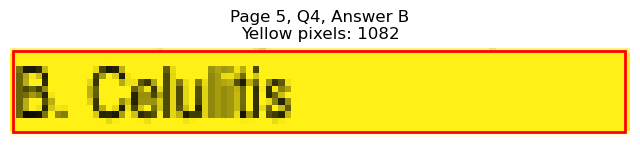

Page 5, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=415.3, y1=354.6
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 493
Page 5, Q4, C: Yellow percentage: 0.0%


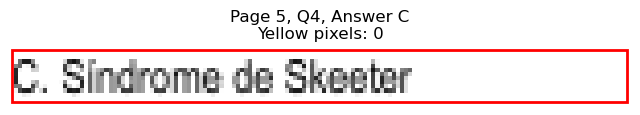

Page 5, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=357.7, y1=367.2
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 184
Page 5, Q4, D: Yellow percentage: 0.0%


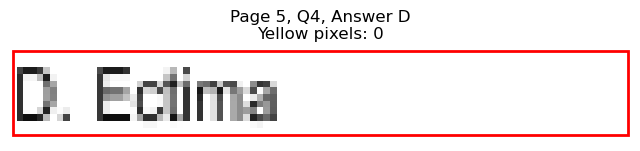


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=130.5, y1=430.3
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 367
Page 5, Q5, A: Yellow percentage: 0.0%


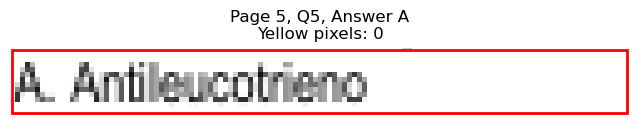

Page 5, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=193.7, y1=442.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 644
Page 5, Q5, B: Yellow percentage: 0.0%


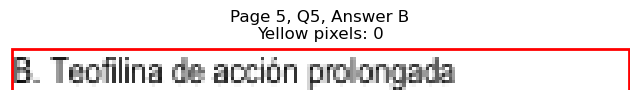

Page 5, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=410.8, y1=430.3
Page 5, Q5, C: Yellow pixels: 146
Page 5, Q5, C: Total non-white pixels: 621
Page 5, Q5, C: Yellow percentage: 23.5%


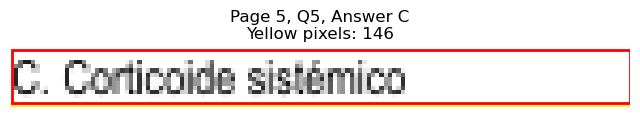

Page 5, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=380.7, y1=442.9
Page 5, Q5, D: Yellow pixels: 1273
Page 5, Q5, D: Total non-white pixels: 1508
Page 5, Q5, D: Yellow percentage: 84.4%


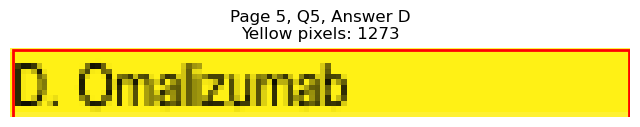


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=493.4, x1=155.1, y1=506.0
Page 5, Q6, A: Yellow pixels: 1595
Page 5, Q6, A: Total non-white pixels: 1956
Page 5, Q6, A: Yellow percentage: 81.5%


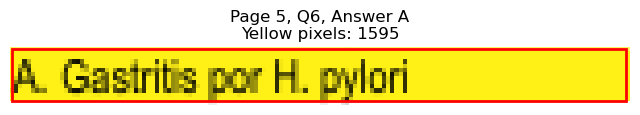

Page 5, Q6 - B: Detected box: x0=56.6, y0=506.0, x1=159.6, y1=518.6
Page 5, Q6, B: Yellow pixels: 148
Page 5, Q6, B: Total non-white pixels: 645
Page 5, Q6, B: Yellow percentage: 22.9%


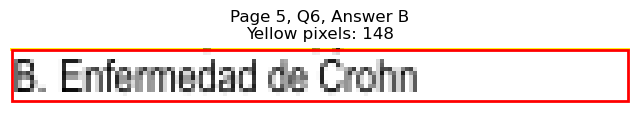

Page 5, Q6 - C: Detected box: x0=315.4, y0=493.4, x1=387.8, y1=506.0
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 361
Page 5, Q6, C: Yellow percentage: 0.0%


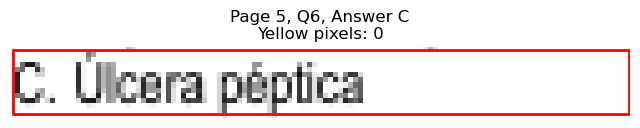

Page 5, Q6 - D: Detected box: x0=315.4, y0=506.0, x1=424.4, y1=518.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 580
Page 5, Q6, D: Yellow percentage: 0.0%


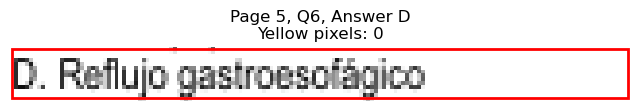


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=556.5, x1=132.0, y1=569.1
Page 5, Q7, A: Yellow pixels: 1374
Page 5, Q7, A: Total non-white pixels: 1778
Page 5, Q7, A: Yellow percentage: 77.3%


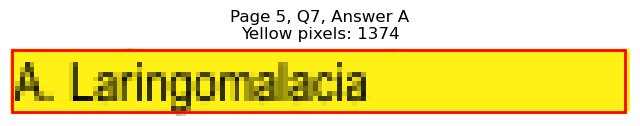

Page 5, Q7 - B: Detected box: x0=56.6, y0=569.1, x1=141.5, y1=581.7
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 530
Page 5, Q7, B: Yellow percentage: 0.0%


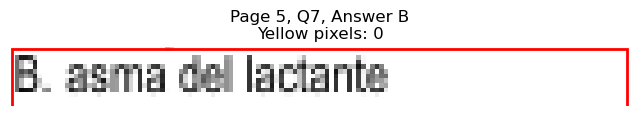

Page 5, Q7 - C: Detected box: x0=315.4, y0=556.5, x1=434.9, y1=569.1
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 576
Page 5, Q7, C: Yellow percentage: 0.0%


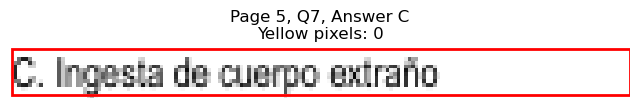

Page 5, Q7 - D: Detected box: x0=315.4, y0=569.1, x1=379.1, y1=581.7
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 319
Page 5, Q7, D: Yellow percentage: 0.0%


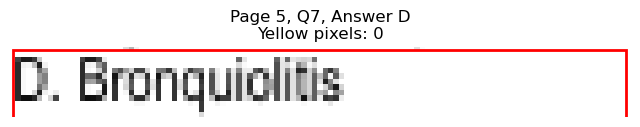


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=75.9, y1=644.9
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 58
Page 5, Q8, A: Yellow percentage: 0.0%


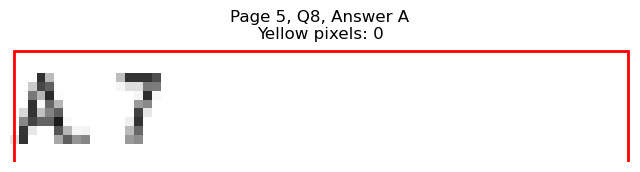

Page 5, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=80.9, y1=657.5
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 106
Page 5, Q8, B: Yellow percentage: 0.0%


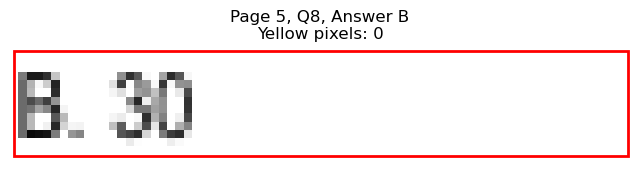

Page 5, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=340.1, y1=644.9
Page 5, Q8, C: Yellow pixels: 932
Page 5, Q8, C: Total non-white pixels: 988
Page 5, Q8, C: Yellow percentage: 94.3%


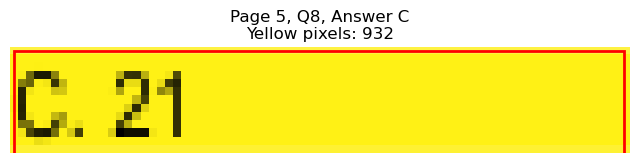

Page 5, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=335.1, y1=657.5
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 70
Page 5, Q8, D: Yellow percentage: 0.0%


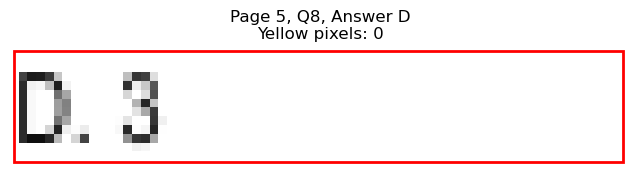


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=708.0, x1=149.1, y1=720.6
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 464
Page 5, Q9, A: Yellow percentage: 0.0%


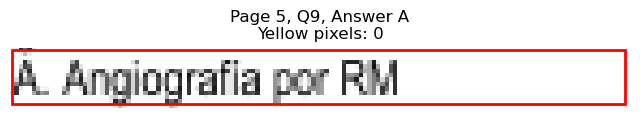

Page 5, Q9 - B: Detected box: x0=56.6, y0=720.6, x1=147.0, y1=733.2
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 443
Page 5, Q9, B: Yellow percentage: 0.0%


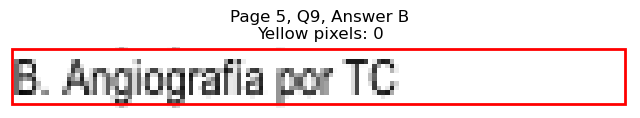

Page 5, Q9 - C: Detected box: x0=315.4, y0=708.0, x1=387.2, y1=720.6
Page 5, Q9, C: Yellow pixels: 123
Page 5, Q9, C: Total non-white pixels: 477
Page 5, Q9, C: Yellow percentage: 25.8%


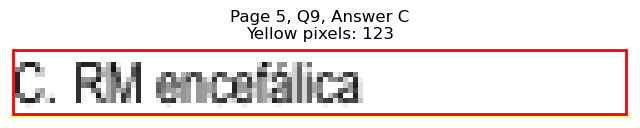

Page 5, Q9 - D: Detected box: x0=315.4, y0=720.6, x1=374.2, y1=733.2
Page 5, Q9, D: Yellow pixels: 1250
Page 5, Q9, D: Total non-white pixels: 1540
Page 5, Q9, D: Yellow percentage: 81.2%


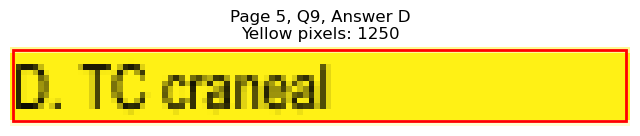


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)

Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=159.0, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 474
Page 6, Q1, A: Yellow percentage: 0.0%


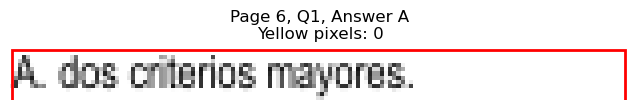

Page 6, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=217.7, y1=127.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 719
Page 6, Q1, B: Yellow percentage: 0.0%


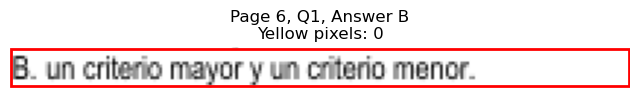

Page 6, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=419.3, y1=114.7
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 641
Page 6, Q1, C: Yellow percentage: 0.0%


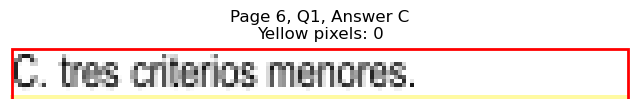

Page 6, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=399.8, y1=127.3
Page 6, Q1, D: Yellow pixels: 1342
Page 6, Q1, D: Total non-white pixels: 1890
Page 6, Q1, D: Yellow percentage: 71.0%


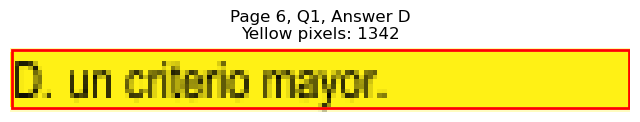


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=233.0, y1=190.4
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 871
Page 6, Q2, A: Yellow percentage: 0.0%


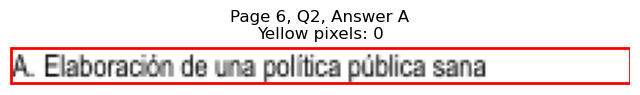

Page 6, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=229.2, y1=203.0
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 831
Page 6, Q2, B: Yellow percentage: 0.0%


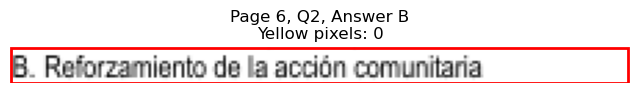

Page 6, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=483.6, y1=190.4
Page 6, Q2, C: Yellow pixels: 1994
Page 6, Q2, C: Total non-white pixels: 3066
Page 6, Q2, C: Yellow percentage: 65.0%


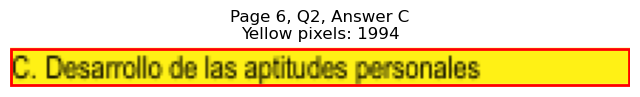

Page 6, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=467.0, y1=203.0
Page 6, Q2, D: Yellow pixels: 2
Page 6, Q2, D: Total non-white pixels: 952
Page 6, Q2, D: Yellow percentage: 0.2%


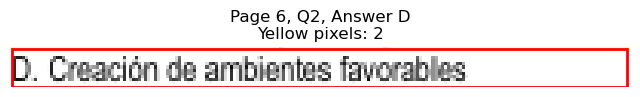


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=234.4, y1=266.1
Page 6, Q3, A: Yellow pixels: 2209
Page 6, Q3, A: Total non-white pixels: 3164
Page 6, Q3, A: Yellow percentage: 69.8%


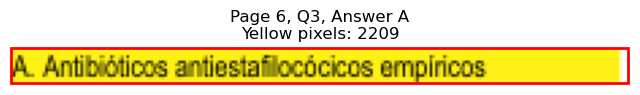

Page 6, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=124.9, y1=278.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 453
Page 6, Q3, B: Yellow percentage: 0.0%


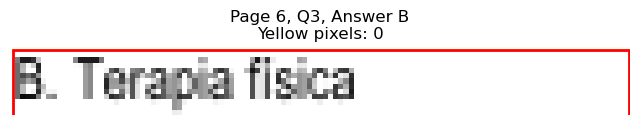

Page 6, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=534.7, y1=266.1
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 1082
Page 6, Q3, C: Yellow percentage: 0.0%


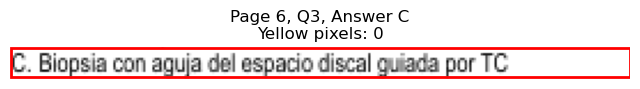

Page 6, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=421.9, y1=278.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 539
Page 6, Q3, D: Yellow percentage: 0.0%


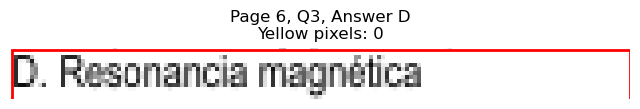


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=124.5, y1=329.2
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 316
Page 6, Q4, A: Yellow percentage: 0.0%


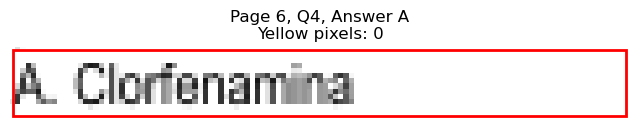

Page 6, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=123.5, y1=341.8
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 321
Page 6, Q4, B: Yellow percentage: 0.0%


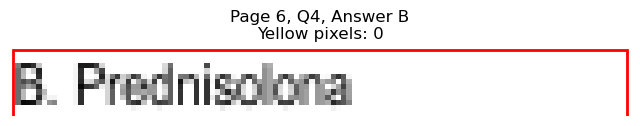

Page 6, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=367.6, y1=329.2
Page 6, Q4, C: Yellow pixels: 103
Page 6, Q4, C: Total non-white pixels: 332
Page 6, Q4, C: Yellow percentage: 31.0%


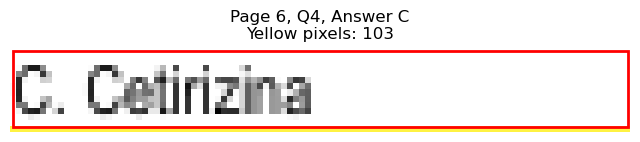

Page 6, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=373.1, y1=341.8
Page 6, Q4, D: Yellow pixels: 1229
Page 6, Q4, D: Total non-white pixels: 1417
Page 6, Q4, D: Yellow percentage: 86.7%


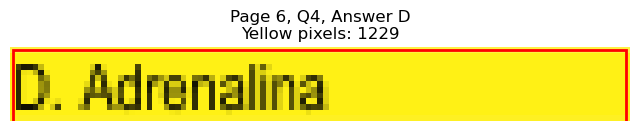


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=126.0, y1=379.8
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 302
Page 6, Q5, A: Yellow percentage: 0.0%


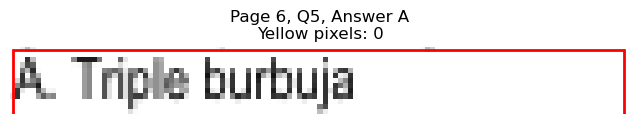

Page 6, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=156.6, y1=392.4
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 505
Page 6, Q5, B: Yellow percentage: 0.0%


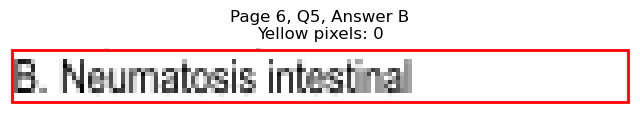

Page 6, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=406.3, y1=379.8
Page 6, Q5, C: Yellow pixels: 1
Page 6, Q5, C: Total non-white pixels: 616
Page 6, Q5, C: Yellow percentage: 0.2%


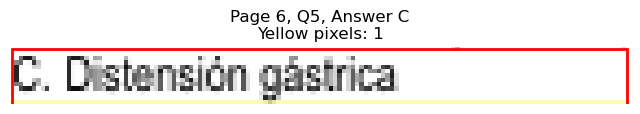

Page 6, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=386.2, y1=392.4
Page 6, Q5, D: Yellow pixels: 1206
Page 6, Q5, D: Total non-white pixels: 1708
Page 6, Q5, D: Yellow percentage: 70.6%


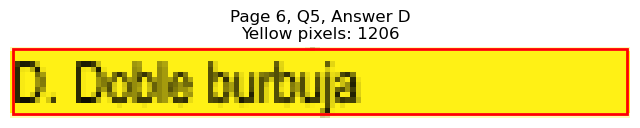


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=106.5, y1=442.9
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 337
Page 6, Q6, A: Yellow percentage: 0.0%


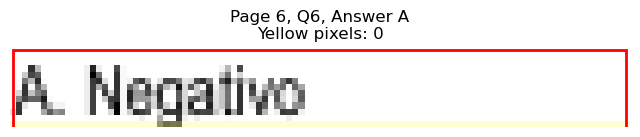

Page 6, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=102.4, y1=455.5
Page 6, Q6, B: Yellow pixels: 1091
Page 6, Q6, B: Total non-white pixels: 1358
Page 6, Q6, B: Yellow percentage: 80.3%


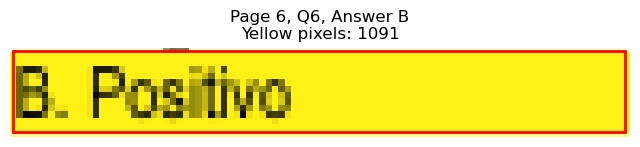

Page 6, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=365.1, y1=442.9
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 197
Page 6, Q6, C: Yellow percentage: 0.0%


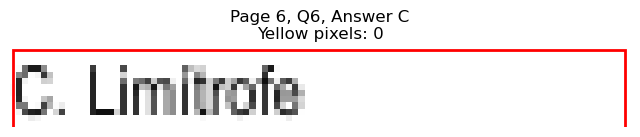

Page 6, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=363.7, y1=455.5
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 207
Page 6, Q6, D: Yellow percentage: 0.0%


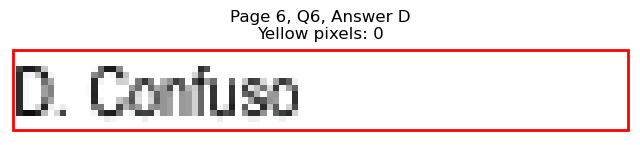


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=150.5, y1=518.6
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 486
Page 6, Q7, A: Yellow percentage: 0.0%


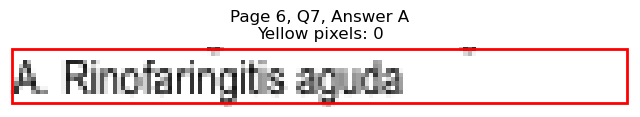

Page 6, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=154.6, y1=531.2
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 487
Page 6, Q7, B: Yellow percentage: 0.0%


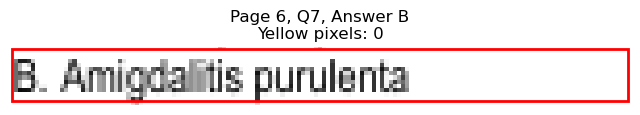

Page 6, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=427.4, y1=518.6
Page 6, Q7, C: Yellow pixels: 1671
Page 6, Q7, C: Total non-white pixels: 2282
Page 6, Q7, C: Yellow percentage: 73.2%


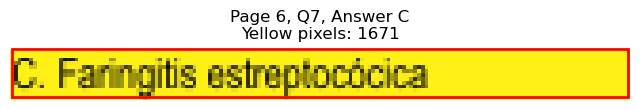

Page 6, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=376.7, y1=531.2
Page 6, Q7, D: Yellow pixels: 111
Page 6, Q7, D: Total non-white pixels: 422
Page 6, Q7, D: Yellow percentage: 26.3%


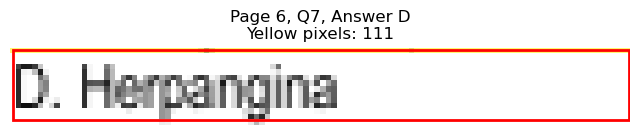


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=76.8, y1=581.7
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 71
Page 6, Q8, A: Yellow percentage: 0.0%


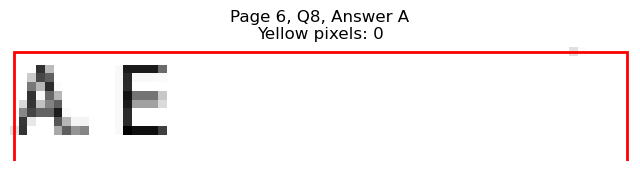

Page 6, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=99.4, y1=594.3
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 205
Page 6, Q8, B: Yellow percentage: 0.0%


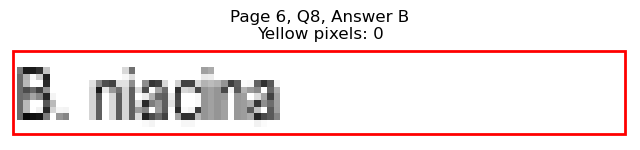

Page 6, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=356.7, y1=581.7
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 279
Page 6, Q8, C: Yellow percentage: 0.0%


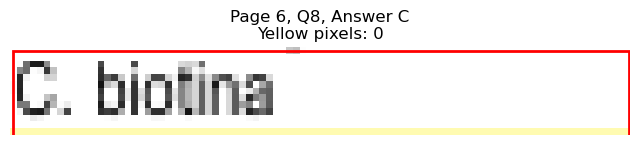

Page 6, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=336.1, y1=594.3
Page 6, Q8, D: Yellow pixels: 811
Page 6, Q8, D: Total non-white pixels: 1008
Page 6, Q8, D: Yellow percentage: 80.5%


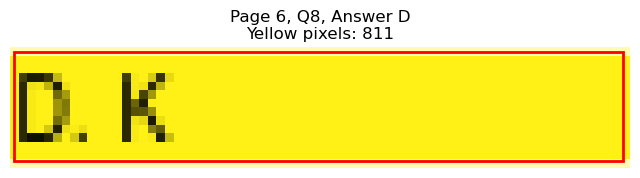


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=657.4, x1=113.9, y1=670.1
Page 6, Q9, A: Yellow pixels: 108
Page 6, Q9, A: Total non-white pixels: 361
Page 6, Q9, A: Yellow percentage: 29.9%


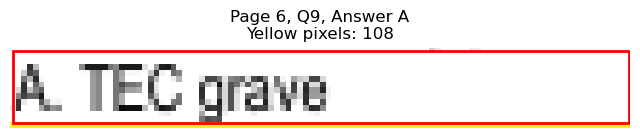

Page 6, Q9 - B: Detected box: x0=56.6, y0=670.0, x1=132.0, y1=682.7
Page 6, Q9, B: Yellow pixels: 1355
Page 6, Q9, B: Total non-white pixels: 1651
Page 6, Q9, B: Yellow percentage: 82.1%


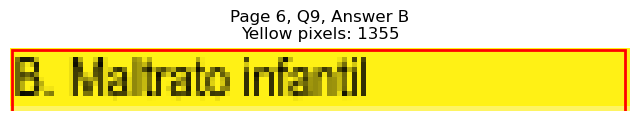

Page 6, Q9 - C: Detected box: x0=315.4, y0=657.4, x1=396.3, y1=670.1
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 386
Page 6, Q9, C: Yellow percentage: 0.0%


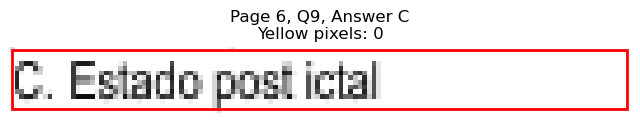

Page 6, Q9 - D: Detected box: x0=315.4, y0=670.0, x1=465.9, y1=682.7
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 754
Page 6, Q9, D: Yellow percentage: 0.0%


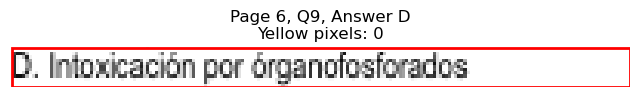


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=708.0, x1=115.9, y1=720.6
Page 6, Q10, A: Yellow pixels: 1228
Page 6, Q10, A: Total non-white pixels: 1540
Page 6, Q10, A: Yellow percentage: 79.7%


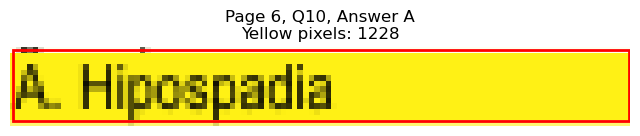

Page 6, Q10 - B: Detected box: x0=56.6, y0=720.6, x1=101.9, y1=733.2
Page 6, Q10, B: Yellow pixels: 96
Page 6, Q10, B: Total non-white pixels: 304
Page 6, Q10, B: Yellow percentage: 31.6%


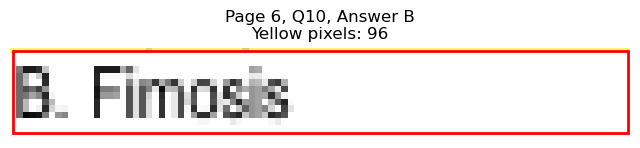

Page 6, Q10 - C: Detected box: x0=315.4, y0=708.0, x1=413.8, y1=720.6
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 465
Page 6, Q10, C: Yellow percentage: 0.0%


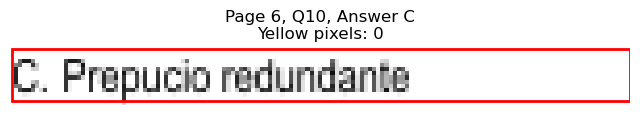

Page 6, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=416.8, y1=733.2
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 505
Page 6, Q10, D: Yellow percentage: 0.0%


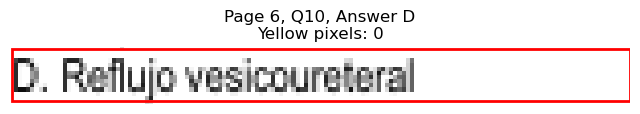


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)

Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=80.9, y1=114.7
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 90
Page 7, Q1, A: Yellow percentage: 0.0%


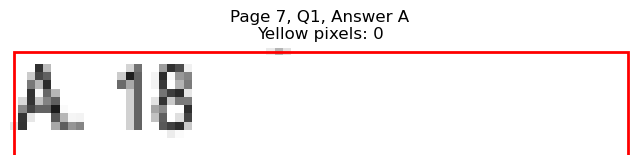

Page 7, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=80.9, y1=127.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 87
Page 7, Q1, B: Yellow percentage: 0.0%


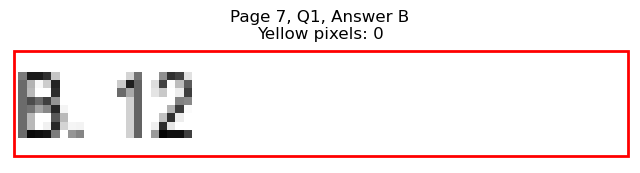

Page 7, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=340.1, y1=114.7
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 156
Page 7, Q1, C: Yellow percentage: 0.0%


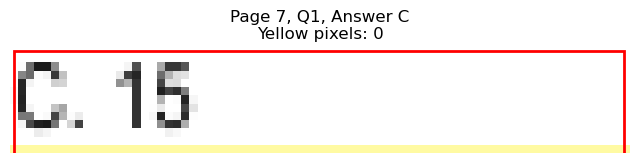

Page 7, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=340.1, y1=127.3
Page 7, Q1, D: Yellow pixels: 839
Page 7, Q1, D: Total non-white pixels: 1064
Page 7, Q1, D: Yellow percentage: 78.9%


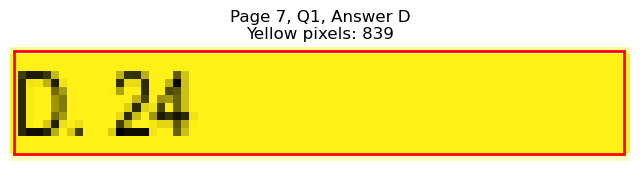


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=164.1, y1=165.2
Page 7, Q2, A: Yellow pixels: 1671
Page 7, Q2, A: Total non-white pixels: 2226
Page 7, Q2, A: Yellow percentage: 75.1%


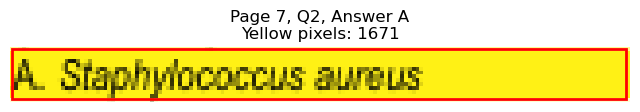

Page 7, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=176.7, y1=177.8
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 748
Page 7, Q2, B: Yellow percentage: 0.0%


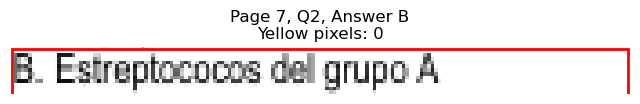

Page 7, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=439.4, y1=165.2
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 602
Page 7, Q2, C: Yellow percentage: 0.0%


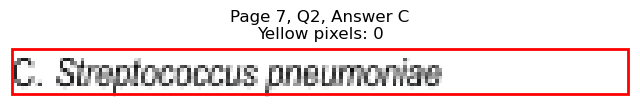

Page 7, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=391.3, y1=177.8
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 381
Page 7, Q2, D: Yellow percentage: 0.0%


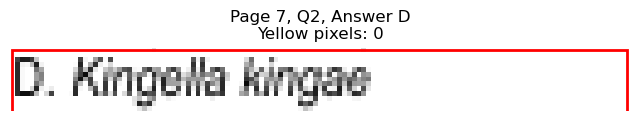


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=171.6, y1=253.5
Page 7, Q3, A: Yellow pixels: 1723
Page 7, Q3, A: Total non-white pixels: 2324
Page 7, Q3, A: Yellow percentage: 74.1%


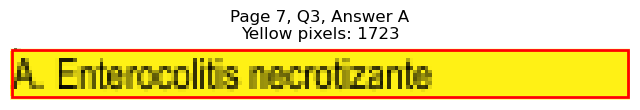

Page 7, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=135.0, y1=266.1
Page 7, Q3, B: Yellow pixels: 130
Page 7, Q3, B: Total non-white pixels: 520
Page 7, Q3, B: Yellow percentage: 25.0%


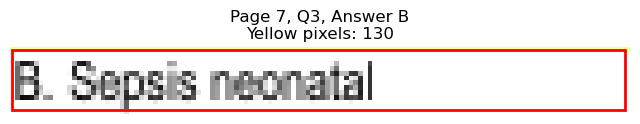

Page 7, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=397.7, y1=253.5
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 410
Page 7, Q3, C: Yellow percentage: 0.0%


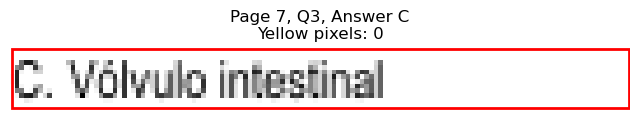

Page 7, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=443.9, y1=266.1
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 644
Page 7, Q3, D: Yellow percentage: 0.0%


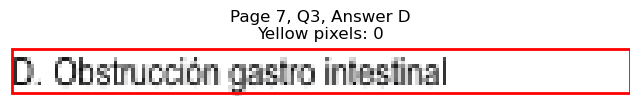


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=164.5, y1=329.2
Page 7, Q4, A: Yellow pixels: 1487
Page 7, Q4, A: Total non-white pixels: 2226
Page 7, Q4, A: Yellow percentage: 66.8%


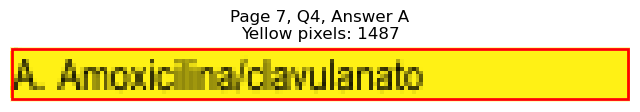

Page 7, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=126.0, y1=341.8
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 449
Page 7, Q4, B: Yellow percentage: 0.0%


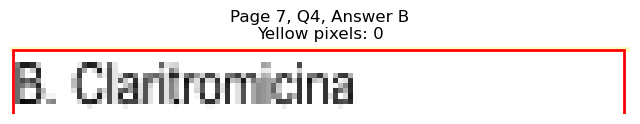

Page 7, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=417.8, y1=329.2
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 500
Page 7, Q4, C: Yellow percentage: 0.0%


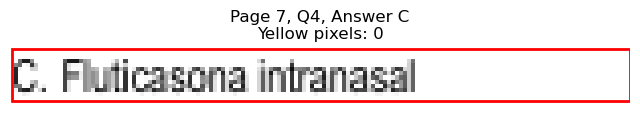

Page 7, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=372.7, y1=341.8
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 263
Page 7, Q4, D: Yellow percentage: 0.0%


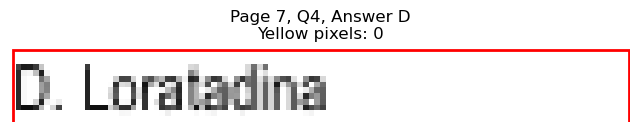


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=108.4, y1=392.4
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 220
Page 7, Q5, A: Yellow percentage: 0.0%


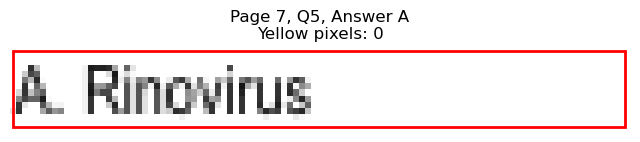

Page 7, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=126.0, y1=405.0
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 330
Page 7, Q5, B: Yellow percentage: 0.0%


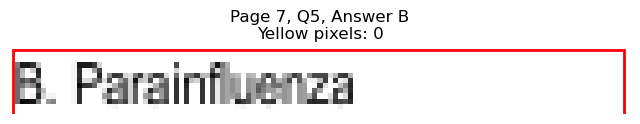

Page 7, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=430.4, y1=392.4
Page 7, Q5, C: Yellow pixels: 1564
Page 7, Q5, C: Total non-white pixels: 2324
Page 7, Q5, C: Yellow percentage: 67.3%


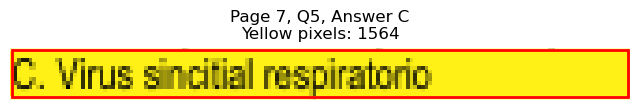

Page 7, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=375.2, y1=405.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 376
Page 7, Q5, D: Yellow percentage: 0.0%


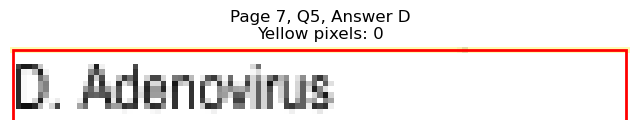


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=185.2, y1=480.7
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 613
Page 7, Q6, A: Yellow percentage: 0.0%


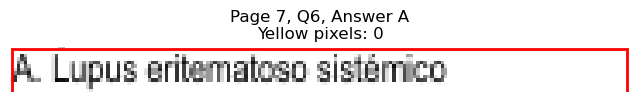

Page 7, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=233.8, y1=493.4
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 892
Page 7, Q6, B: Yellow percentage: 0.0%


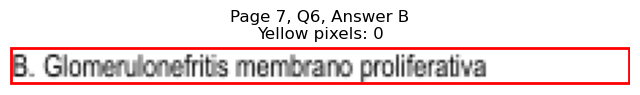

Page 7, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=431.3, y1=480.7
Page 7, Q6, C: Yellow pixels: 1730
Page 7, Q6, C: Total non-white pixels: 2171
Page 7, Q6, C: Yellow percentage: 79.7%


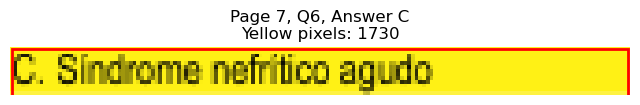

Page 7, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=407.3, y1=493.4
Page 7, Q6, D: Yellow pixels: 141
Page 7, Q6, D: Total non-white pixels: 592
Page 7, Q6, D: Yellow percentage: 23.8%


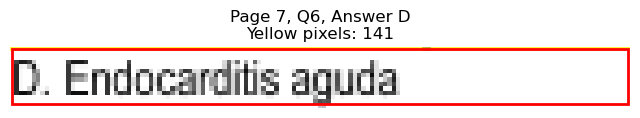


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=569.1, x1=153.6, y1=581.7
Page 7, Q7, A: Yellow pixels: 1
Page 7, Q7, A: Total non-white pixels: 627
Page 7, Q7, A: Yellow percentage: 0.2%


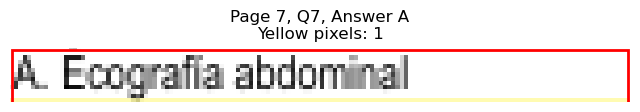

Page 7, Q7 - B: Detected box: x0=56.6, y0=581.7, x1=210.8, y1=594.3
Page 7, Q7, B: Yellow pixels: 1864
Page 7, Q7, B: Total non-white pixels: 2870
Page 7, Q7, B: Yellow percentage: 64.9%


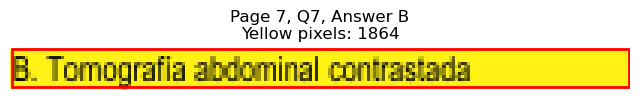

Page 7, Q7 - C: Detected box: x0=315.4, y0=569.1, x1=429.4, y1=581.7
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 573
Page 7, Q7, C: Yellow percentage: 0.0%


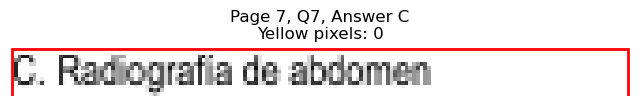

Page 7, Q7 - D: Detected box: x0=315.4, y0=581.7, x1=353.1, y1=594.3
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 159
Page 7, Q7, D: Yellow percentage: 0.0%


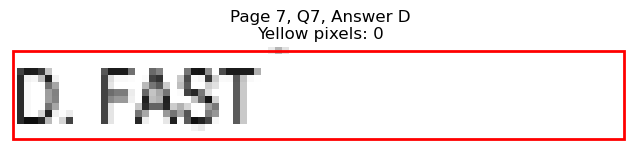


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=644.8, x1=186.1, y1=657.5
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 597
Page 7, Q8, A: Yellow percentage: 0.0%


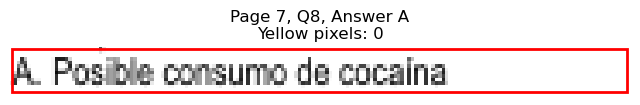

Page 7, Q8 - B: Detected box: x0=56.6, y0=657.4, x1=139.0, y1=670.1
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 401
Page 7, Q8, B: Yellow percentage: 0.0%


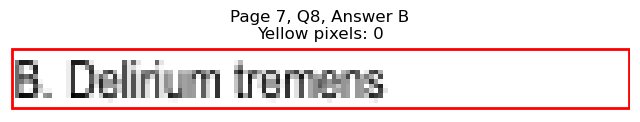

Page 7, Q8 - C: Detected box: x0=315.4, y0=644.8, x1=457.0, y1=657.5
Page 7, Q8, C: Yellow pixels: 1963
Page 7, Q8, C: Total non-white pixels: 2702
Page 7, Q8, C: Yellow percentage: 72.6%


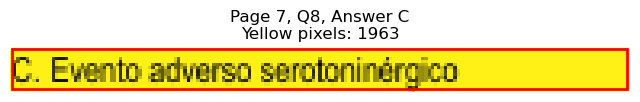

Page 7, Q8 - D: Detected box: x0=315.4, y0=657.4, x1=447.4, y1=670.1
Page 7, Q8, D: Yellow pixels: 182
Page 7, Q8, D: Total non-white pixels: 840
Page 7, Q8, D: Yellow percentage: 21.7%


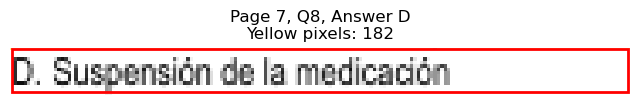


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=720.6, x1=154.1, y1=733.2
Page 7, Q9, A: Yellow pixels: 1580
Page 7, Q9, A: Total non-white pixels: 2086
Page 7, Q9, A: Yellow percentage: 75.7%


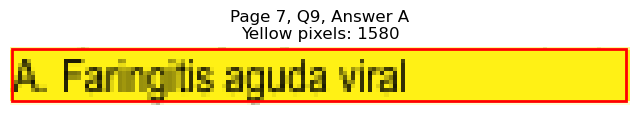

Page 7, Q9 - B: Detected box: x0=56.6, y0=733.2, x1=168.1, y1=745.8
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 741
Page 7, Q9, B: Yellow percentage: 0.0%


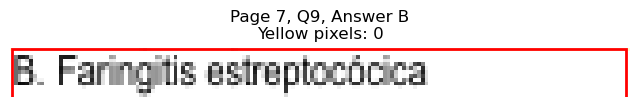

Page 7, Q9 - C: Detected box: x0=315.4, y0=720.6, x1=436.4, y1=733.2
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 610
Page 7, Q9, C: Yellow percentage: 0.0%


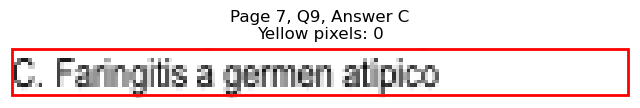

Page 7, Q9 - D: Detected box: x0=315.4, y0=733.2, x1=432.9, y1=745.8
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 592
Page 7, Q9, D: Yellow percentage: 0.0%


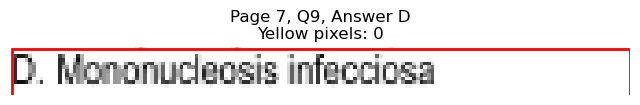


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)

Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=160.6, y1=127.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 496
Page 8, Q1, A: Yellow percentage: 0.0%


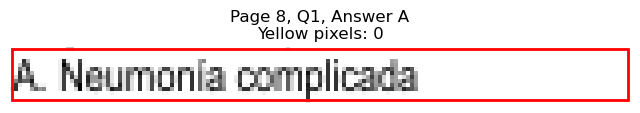

Page 8, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=117.5, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 308
Page 8, Q1, B: Yellow percentage: 0.0%


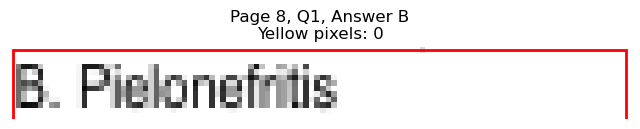

Page 8, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=420.8, y1=127.3
Page 8, Q1, C: Yellow pixels: 156
Page 8, Q1, C: Total non-white pixels: 649
Page 8, Q1, C: Yellow percentage: 24.0%


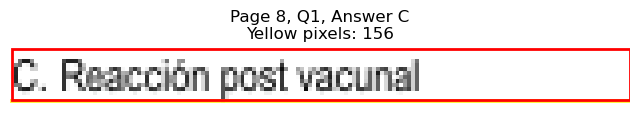

Page 8, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=386.2, y1=139.9
Page 8, Q1, D: Yellow pixels: 1330
Page 8, Q1, D: Total non-white pixels: 1586
Page 8, Q1, D: Yellow percentage: 83.9%


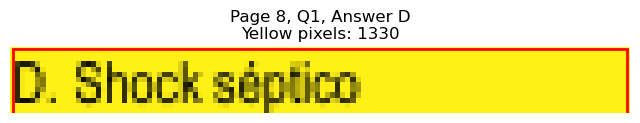


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=160.6, y1=215.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 527
Page 8, Q2, A: Yellow percentage: 0.0%


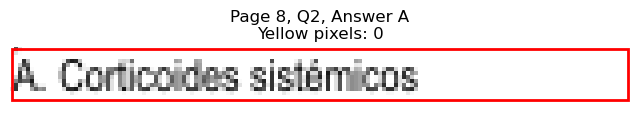

Page 8, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=147.0, y1=228.3
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 455
Page 8, Q2, B: Yellow percentage: 0.0%


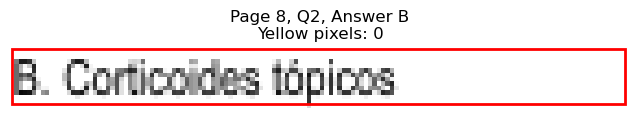

Page 8, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=407.3, y1=215.6
Page 8, Q2, C: Yellow pixels: 1499
Page 8, Q2, C: Total non-white pixels: 2002
Page 8, Q2, C: Yellow percentage: 74.9%


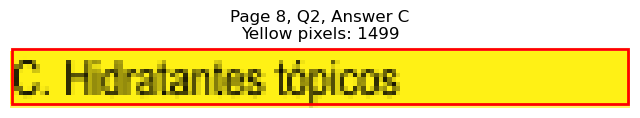

Page 8, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=478.1, y1=228.3
Page 8, Q2, D: Yellow pixels: 214
Page 8, Q2, D: Total non-white pixels: 992
Page 8, Q2, D: Yellow percentage: 21.6%


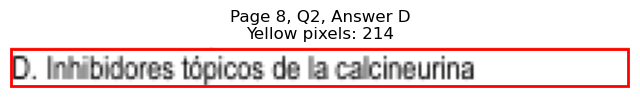


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=291.4, x1=115.5, y1=304.0
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 243
Page 8, Q3, A: Yellow percentage: 0.0%


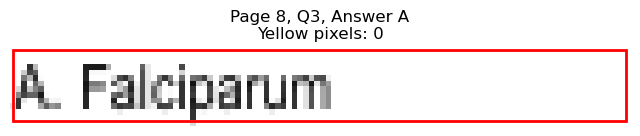

Page 8, Q3 - B: Detected box: x0=56.6, y0=304.0, x1=105.4, y1=316.6
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 255
Page 8, Q3, B: Yellow percentage: 0.0%


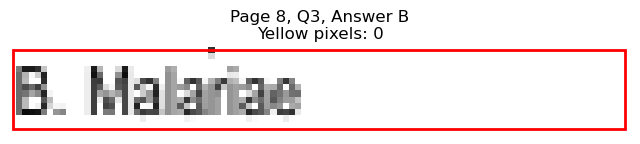

Page 8, Q3 - C: Detected box: x0=315.4, y0=291.4, x1=353.6, y1=304.0
Page 8, Q3, C: Yellow pixels: 89
Page 8, Q3, C: Total non-white pixels: 249
Page 8, Q3, C: Yellow percentage: 35.7%


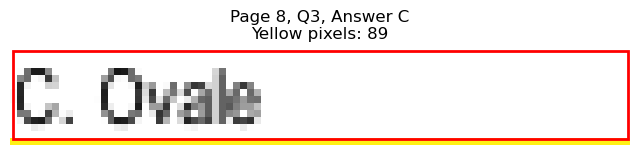

Page 8, Q3 - D: Detected box: x0=315.4, y0=304.0, x1=352.6, y1=316.6
Page 8, Q3, D: Yellow pixels: 1027
Page 8, Q3, D: Total non-white pixels: 1144
Page 8, Q3, D: Yellow percentage: 89.8%


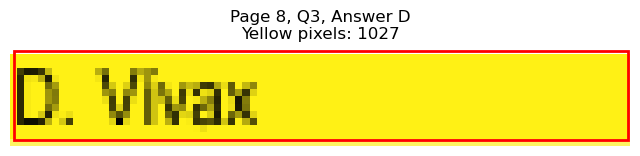


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=354.5, x1=164.1, y1=367.2
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 516
Page 8, Q4, A: Yellow percentage: 0.0%


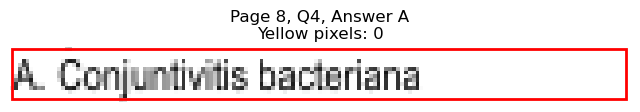

Page 8, Q4 - B: Detected box: x0=56.6, y0=367.1, x1=153.5, y1=379.8
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 485
Page 8, Q4, B: Yellow percentage: 0.0%


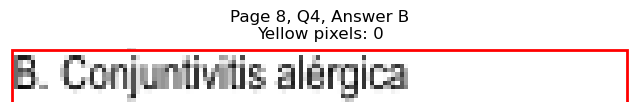

Page 8, Q4 - C: Detected box: x0=315.4, y0=354.5, x1=394.3, y1=367.2
Page 8, Q4, C: Yellow pixels: 1400
Page 8, Q4, C: Total non-white pixels: 1820
Page 8, Q4, C: Yellow percentage: 76.9%


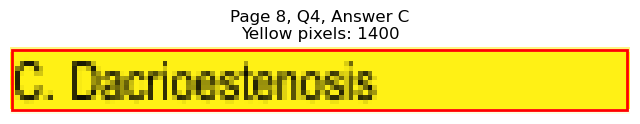

Page 8, Q4 - D: Detected box: x0=315.4, y0=367.1, x1=380.7, y1=379.8
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 433
Page 8, Q4, D: Yellow percentage: 0.0%


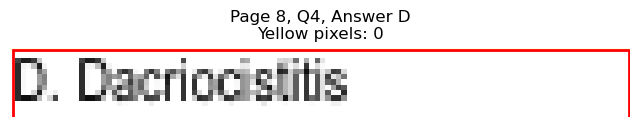


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=108.4, y1=417.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 248
Page 8, Q5, A: Yellow percentage: 0.0%


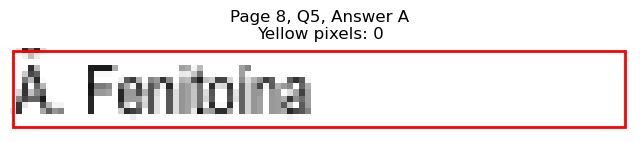

Page 8, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=121.0, y1=430.3
Page 8, Q5, B: Yellow pixels: 1117
Page 8, Q5, B: Total non-white pixels: 1610
Page 8, Q5, B: Yellow percentage: 69.4%


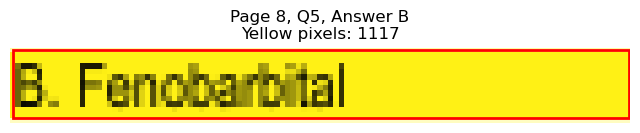

Page 8, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=370.6, y1=417.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 261
Page 8, Q5, C: Yellow percentage: 0.0%


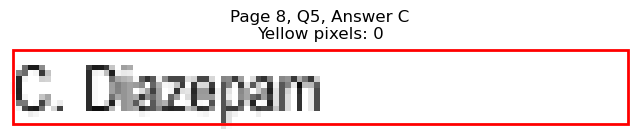

Page 8, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=375.7, y1=430.3
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 292
Page 8, Q5, D: Yellow percentage: 0.0%


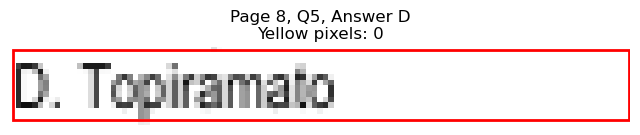


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=179.8, y1=493.4
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 610
Page 8, Q6, A: Yellow percentage: 0.0%


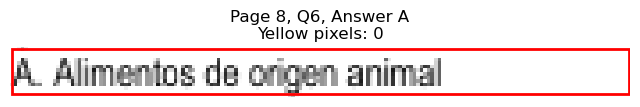

Page 8, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=231.8, y1=506.0
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 834
Page 8, Q6, B: Yellow percentage: 0.0%


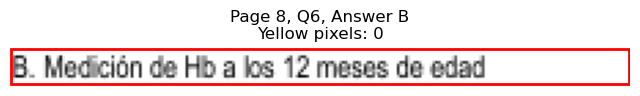

Page 8, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=523.2, y1=493.4
Page 8, Q6, C: Yellow pixels: 225
Page 8, Q6, C: Total non-white pixels: 1229
Page 8, Q6, C: Yellow percentage: 18.3%


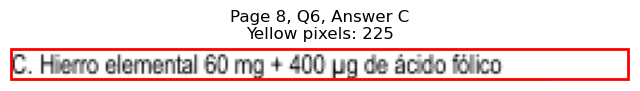

Page 8, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=453.9, y1=506.0
Page 8, Q6, D: Yellow pixels: 1916
Page 8, Q6, D: Total non-white pixels: 2462
Page 8, Q6, D: Yellow percentage: 77.8%


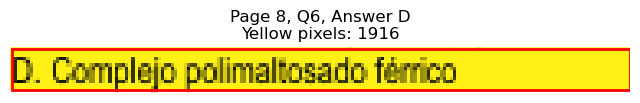


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=234.3, y1=543.8
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 1062
Page 8, Q7, A: Yellow percentage: 0.0%


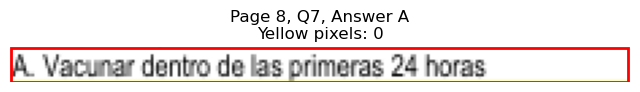

Page 8, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=296.9, y1=556.4
Page 8, Q7, B: Yellow pixels: 2850
Page 8, Q7, B: Total non-white pixels: 4074
Page 8, Q7, B: Yellow percentage: 70.0%


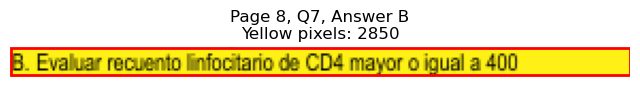

Page 8, Q7 - C: Detected box: x0=56.6, y0=556.5, x1=199.2, y1=569.1
Page 8, Q7, C: Yellow pixels: 193
Page 8, Q7, C: Total non-white pixels: 847
Page 8, Q7, C: Yellow percentage: 22.8%


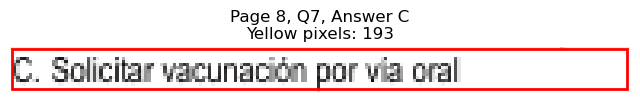

Page 8, Q7 - D: Detected box: x0=56.6, y0=569.1, x1=249.9, y1=581.7
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 863
Page 8, Q7, D: Yellow percentage: 0.0%


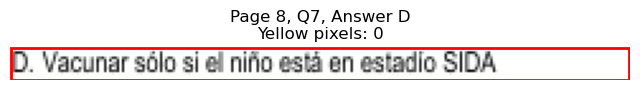


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=141.0, y1=632.3
Page 8, Q8, A: Yellow pixels: 136
Page 8, Q8, A: Total non-white pixels: 509
Page 8, Q8, A: Yellow percentage: 26.7%


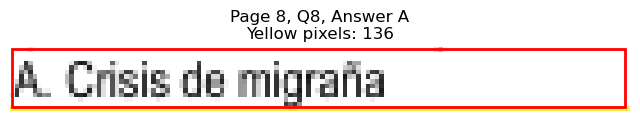

Page 8, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=146.5, y1=644.9
Page 8, Q8, B: Yellow pixels: 1488
Page 8, Q8, B: Total non-white pixels: 1833
Page 8, Q8, B: Yellow percentage: 81.2%


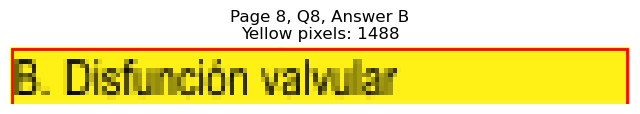

Page 8, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=370.6, y1=632.3
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 283
Page 8, Q8, C: Yellow percentage: 0.0%


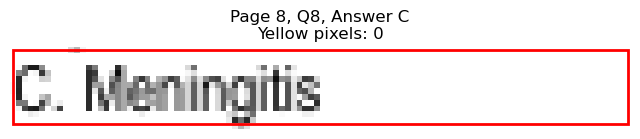

Page 8, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=426.8, y1=644.9
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 555
Page 8, Q8, D: Yellow percentage: 0.0%


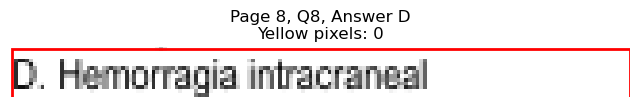


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=682.6, x1=171.1, y1=695.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 520
Page 8, Q9, A: Yellow percentage: 0.0%


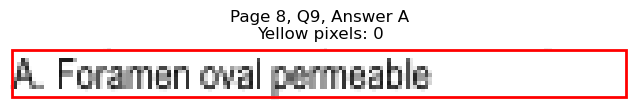

Page 8, Q9 - B: Detected box: x0=56.6, y0=695.4, x1=193.7, y1=708.0
Page 8, Q9, B: Yellow pixels: 1921
Page 8, Q9, B: Total non-white pixels: 2446
Page 8, Q9, B: Yellow percentage: 78.5%


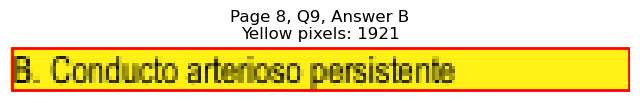

Page 8, Q9 - C: Detected box: x0=315.4, y0=682.6, x1=428.3, y1=695.3
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 547
Page 8, Q9, C: Yellow percentage: 0.0%


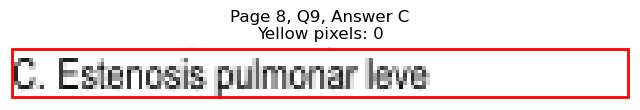

Page 8, Q9 - D: Detected box: x0=315.4, y0=695.4, x1=479.5, y1=708.0
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 801
Page 8, Q9, D: Yellow percentage: 0.0%


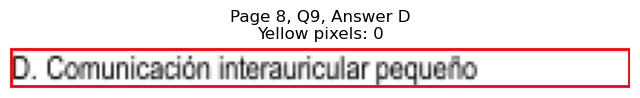


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=135.5, y1=745.8
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 372
Page 8, Q10, A: Yellow percentage: 0.0%


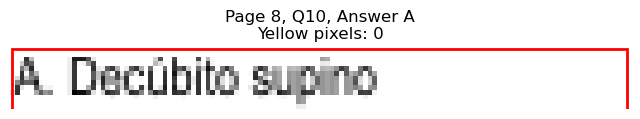

Page 8, Q10 - B: Detected box: x0=56.6, y0=745.8, x1=133.5, y1=758.4
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 366
Page 8, Q10, B: Yellow percentage: 0.0%


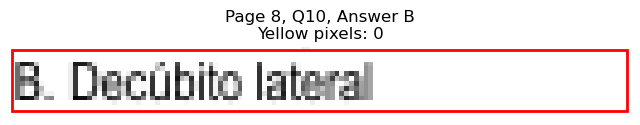

Page 8, Q10 - C: Detected box: x0=315.4, y0=733.2, x1=388.7, y1=745.8
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 484
Page 8, Q10, C: Yellow percentage: 0.0%


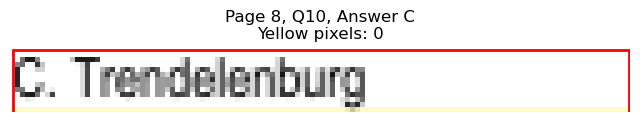

Page 8, Q10 - D: Detected box: x0=315.4, y0=745.8, x1=388.8, y1=758.4
Page 8, Q10, D: Yellow pixels: 1344
Page 8, Q10, D: Total non-white pixels: 1736
Page 8, Q10, D: Yellow percentage: 77.4%


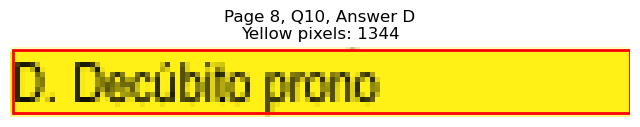


Page 8, Q10 - Selected Answer: D (based on yellow pixel count)

Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=76.8, y1=114.7
Page 9, Q1, A: Yellow pixels: 873
Page 9, Q1, A: Total non-white pixels: 923
Page 9, Q1, A: Yellow percentage: 94.6%


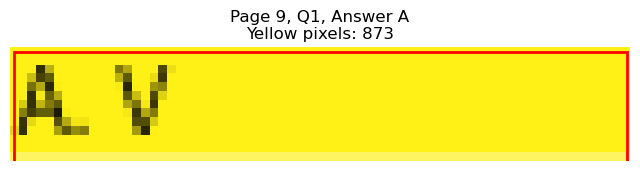

Page 9, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=78.4, y1=127.3
Page 9, Q1, B: Yellow pixels: 73
Page 9, Q1, B: Total non-white pixels: 147
Page 9, Q1, B: Yellow percentage: 49.7%


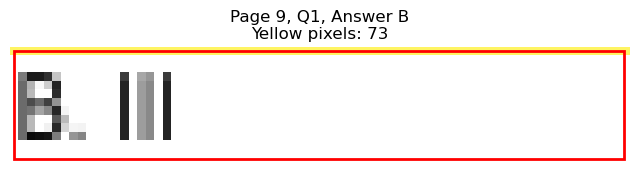

Page 9, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=338.6, y1=114.7
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 84
Page 9, Q1, C: Yellow percentage: 0.0%


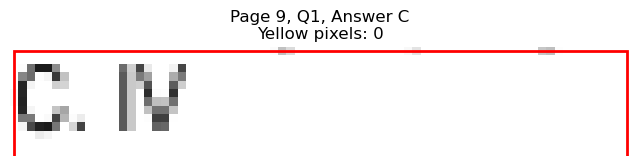

Page 9, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=335.1, y1=127.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 72
Page 9, Q1, D: Yellow percentage: 0.0%


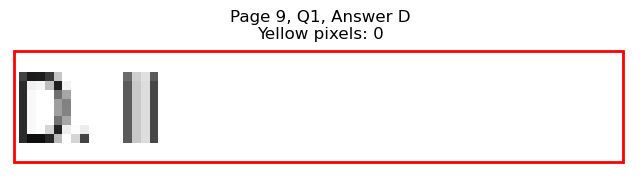


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=118.5, y1=190.4
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 307
Page 9, Q2, A: Yellow percentage: 0.0%


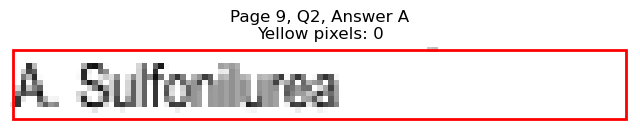

Page 9, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=115.9, y1=203.0
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 283
Page 9, Q2, B: Yellow percentage: 0.0%


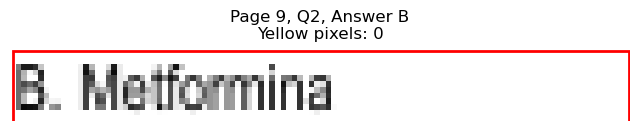

Page 9, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=396.8, y1=190.4
Page 9, Q2, C: Yellow pixels: 1260
Page 9, Q2, C: Total non-white pixels: 1848
Page 9, Q2, C: Yellow percentage: 68.2%


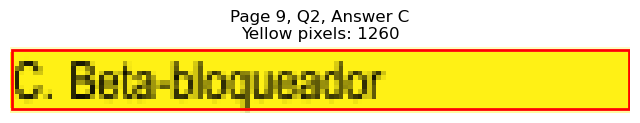

Page 9, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=373.1, y1=203.0
Page 9, Q2, D: Yellow pixels: 1
Page 9, Q2, D: Total non-white pixels: 416
Page 9, Q2, D: Yellow percentage: 0.2%


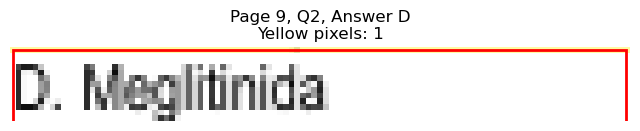


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=109.0, y1=253.5
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 243
Page 9, Q3, A: Yellow percentage: 0.0%


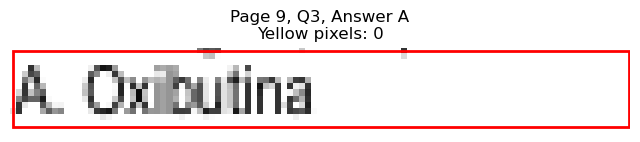

Page 9, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=173.2, y1=266.1
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 583
Page 9, Q3, B: Yellow percentage: 0.0%


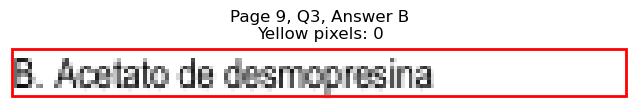

Page 9, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=380.2, y1=253.5
Page 9, Q3, C: Yellow pixels: 1274
Page 9, Q3, C: Total non-white pixels: 1624
Page 9, Q3, C: Yellow percentage: 78.4%


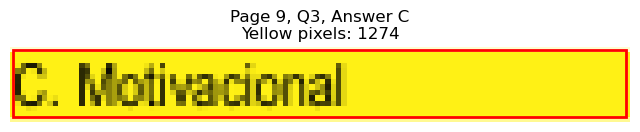

Page 9, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=371.7, y1=266.1
Page 9, Q3, D: Yellow pixels: 107
Page 9, Q3, D: Total non-white pixels: 370
Page 9, Q3, D: Yellow percentage: 28.9%


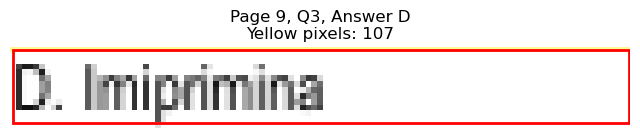


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=117.5, y1=329.2
Page 9, Q4, A: Yellow pixels: 1104
Page 9, Q4, A: Total non-white pixels: 1568
Page 9, Q4, A: Yellow percentage: 70.4%


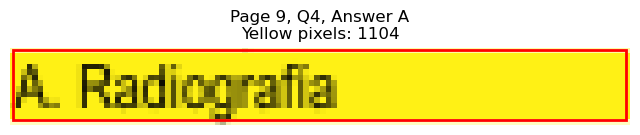

Page 9, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=116.9, y1=341.8
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 384
Page 9, Q4, B: Yellow percentage: 0.0%


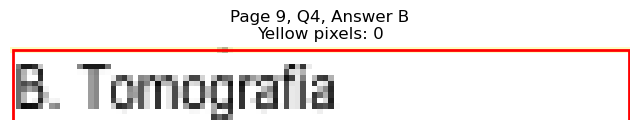

Page 9, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=383.7, y1=329.2
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 352
Page 9, Q4, C: Yellow percentage: 0.0%


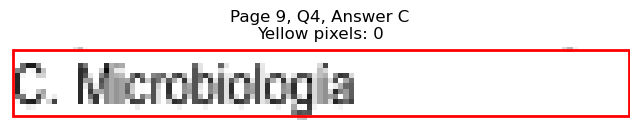

Page 9, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=368.7, y1=341.8
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 257
Page 9, Q4, D: Yellow percentage: 0.0%


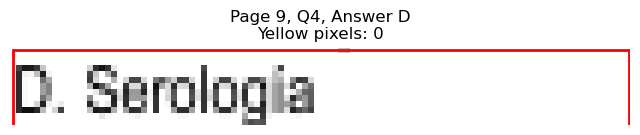


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=136.0, y1=417.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 379
Page 9, Q5, A: Yellow percentage: 0.0%


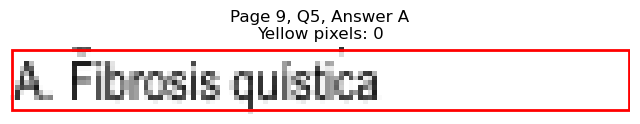

Page 9, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=133.5, y1=430.3
Page 9, Q5, B: Yellow pixels: 1221
Page 9, Q5, B: Total non-white pixels: 1792
Page 9, Q5, B: Yellow percentage: 68.1%


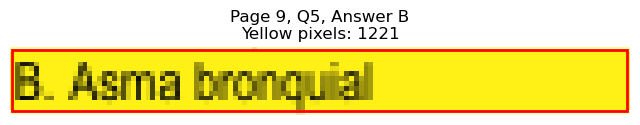

Page 9, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=487.5, y1=417.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 881
Page 9, Q5, C: Yellow percentage: 0.0%


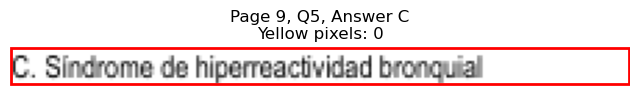

Page 9, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=453.4, y1=430.3
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 664
Page 9, Q5, D: Yellow percentage: 0.0%


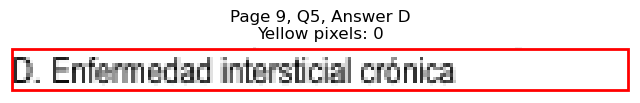


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=184.7, y1=493.4
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 642
Page 9, Q6, A: Yellow percentage: 0.0%


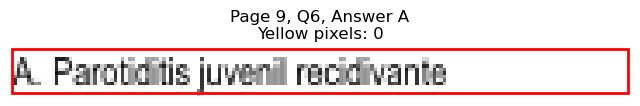

Page 9, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=153.0, y1=506.0
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 487
Page 9, Q6, B: Yellow percentage: 0.0%


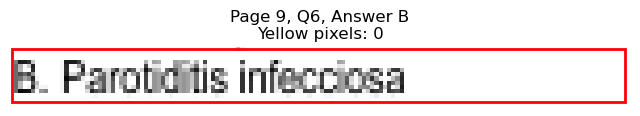

Page 9, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=376.7, y1=493.4
Page 9, Q6, C: Yellow pixels: 112
Page 9, Q6, C: Total non-white pixels: 405
Page 9, Q6, C: Yellow percentage: 27.7%


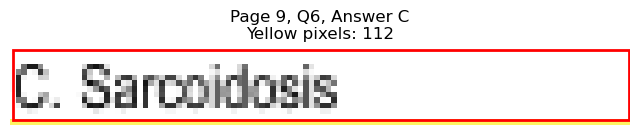

Page 9, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=415.3, y1=506.0
Page 9, Q6, D: Yellow pixels: 1576
Page 9, Q6, D: Total non-white pixels: 1967
Page 9, Q6, D: Yellow percentage: 80.1%


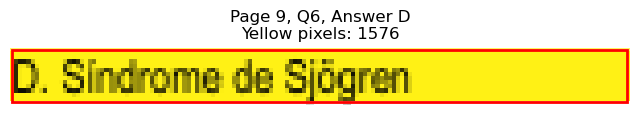


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=109.5, y1=543.8
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 259
Page 9, Q7, A: Yellow percentage: 0.0%


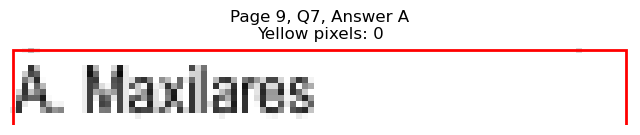

Page 9, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=122.4, y1=556.4
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 318
Page 9, Q7, B: Yellow percentage: 0.0%


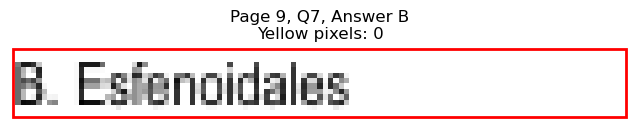

Page 9, Q7 - C: Detected box: x0=315.4, y0=531.2, x1=367.6, y1=543.8
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 340
Page 9, Q7, C: Yellow percentage: 0.0%


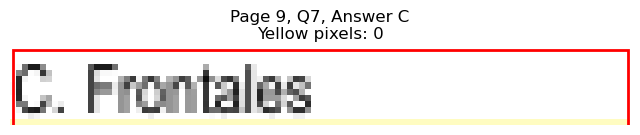

Page 9, Q7 - D: Detected box: x0=315.4, y0=543.8, x1=374.7, y1=556.4
Page 9, Q7, D: Yellow pixels: 1221
Page 9, Q7, D: Total non-white pixels: 1540
Page 9, Q7, D: Yellow percentage: 79.3%


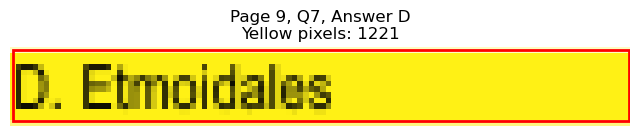


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=606.9, x1=117.5, y1=619.5
Page 9, Q8, A: Yellow pixels: 1231
Page 9, Q8, A: Total non-white pixels: 1568
Page 9, Q8, A: Yellow percentage: 78.5%


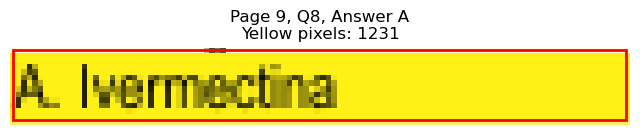

Page 9, Q8 - B: Detected box: x0=56.6, y0=619.6, x1=120.0, y1=632.3
Page 9, Q8, B: Yellow pixels: 115
Page 9, Q8, B: Total non-white pixels: 439
Page 9, Q8, B: Yellow percentage: 26.2%


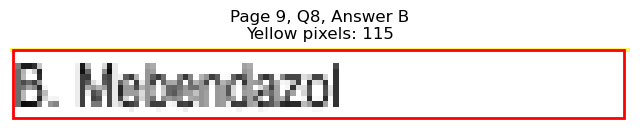

Page 9, Q8 - C: Detected box: x0=315.4, y0=606.9, x1=410.8, y1=619.5
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 455
Page 9, Q8, C: Yellow percentage: 0.0%


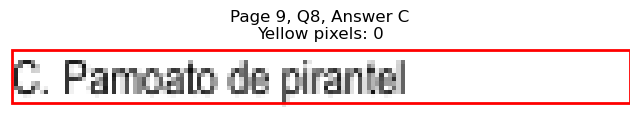

Page 9, Q8 - D: Detected box: x0=315.4, y0=619.6, x1=379.7, y1=632.3
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 296
Page 9, Q8, D: Yellow percentage: 0.0%


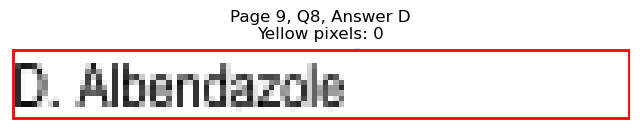


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=165.1, y1=708.0
Page 9, Q9, A: Yellow pixels: 1673
Page 9, Q9, A: Total non-white pixels: 2083
Page 9, Q9, A: Yellow percentage: 80.3%


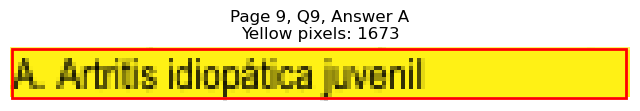

Page 9, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=185.2, y1=720.6
Page 9, Q9, B: Yellow pixels: 176
Page 9, Q9, B: Total non-white pixels: 801
Page 9, Q9, B: Yellow percentage: 22.0%


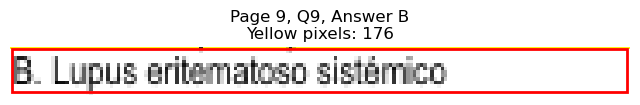

Page 9, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=425.3, y1=708.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 537
Page 9, Q9, C: Yellow percentage: 0.0%


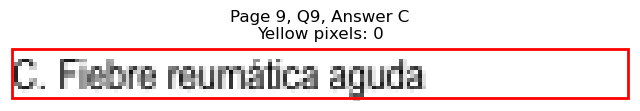

Page 9, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=389.7, y1=720.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 351
Page 9, Q9, D: Yellow percentage: 0.0%


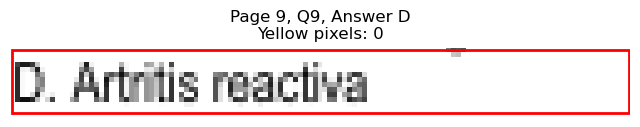


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)

Page 10: Found 11 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=136.5, y1=114.7
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 508
Page 10, Q1, A: Yellow percentage: 0.0%


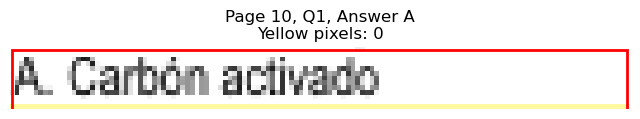

Page 10, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=132.5, y1=127.3
Page 10, Q1, B: Yellow pixels: 1220
Page 10, Q1, B: Total non-white pixels: 1778
Page 10, Q1, B: Yellow percentage: 68.6%


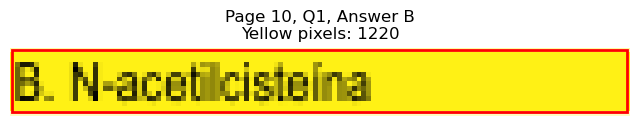

Page 10, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=368.2, y1=114.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 241
Page 10, Q1, C: Yellow percentage: 0.0%


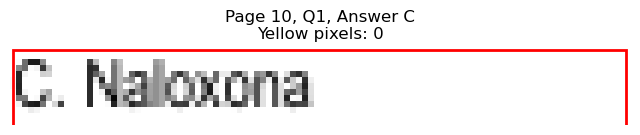

Page 10, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=368.7, y1=127.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 238
Page 10, Q1, D: Yellow percentage: 0.0%


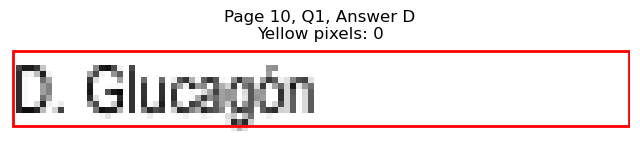


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=170.1, y1=177.8
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 546
Page 10, Q2, A: Yellow percentage: 0.0%


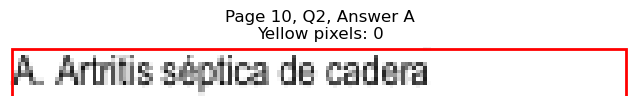

Page 10, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=166.1, y1=190.4
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 530
Page 10, Q2, B: Yellow percentage: 0.0%


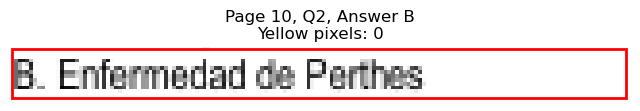

Page 10, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=408.8, y1=177.8
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 562
Page 10, Q2, C: Yellow percentage: 0.0%


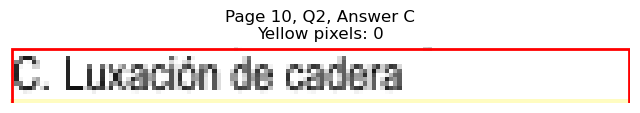

Page 10, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=459.4, y1=190.4
Page 10, Q2, D: Yellow pixels: 1822
Page 10, Q2, D: Total non-white pixels: 2730
Page 10, Q2, D: Yellow percentage: 66.7%


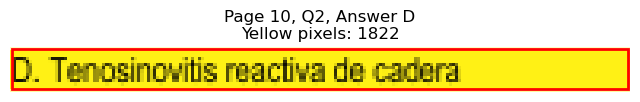


Page 10, Q2 - Selected Answer: D (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=130.9, y1=228.3
Page 10, Q3, A: Yellow pixels: 125
Page 10, Q3, A: Total non-white pixels: 466
Page 10, Q3, A: Yellow percentage: 26.8%


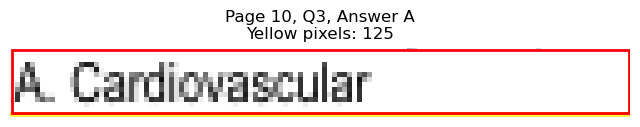

Page 10, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=136.0, y1=240.9
Page 10, Q3, B: Yellow pixels: 1399
Page 10, Q3, B: Total non-white pixels: 1690
Page 10, Q3, B: Yellow percentage: 82.8%


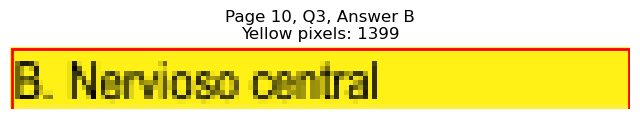

Page 10, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=392.7, y1=228.3
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 391
Page 10, Q3, C: Yellow percentage: 0.0%


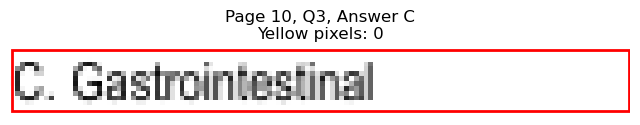

Page 10, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=372.7, y1=240.9
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 249
Page 10, Q3, D: Yellow percentage: 0.0%


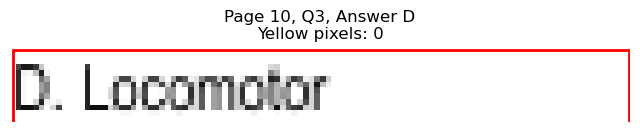


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)
Page 10, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=109.9, y1=316.6
Page 10, Q4, A: Yellow pixels: 1172
Page 10, Q4, A: Total non-white pixels: 1361
Page 10, Q4, A: Yellow percentage: 86.1%


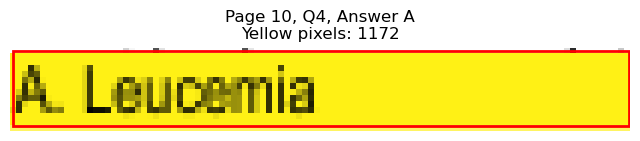

Page 10, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=135.5, y1=329.2
Page 10, Q4, B: Yellow pixels: 130
Page 10, Q4, B: Total non-white pixels: 528
Page 10, Q4, B: Yellow percentage: 24.6%


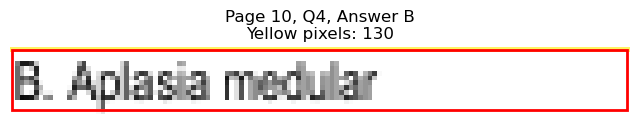

Page 10, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=362.1, y1=316.6
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 191
Page 10, Q4, C: Yellow percentage: 0.0%


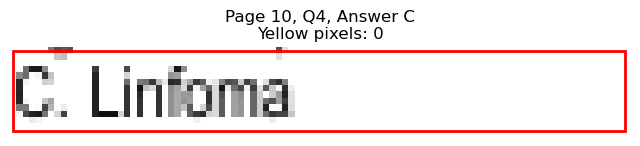

Page 10, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=446.9, y1=329.2
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 627
Page 10, Q4, D: Yellow percentage: 0.0%


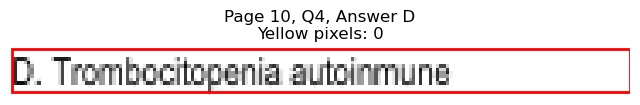


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)
Page 10, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=108.4, y1=379.8
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 223
Page 10, Q5, A: Yellow percentage: 0.0%


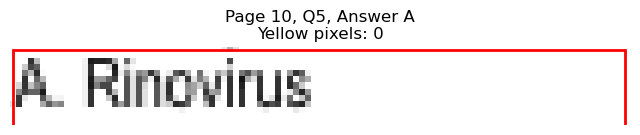

Page 10, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=142.6, y1=392.4
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 398
Page 10, Q5, B: Yellow percentage: 0.0%


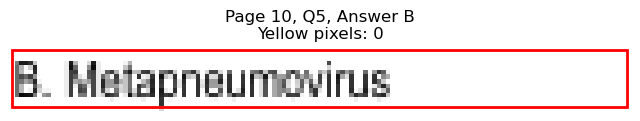

Page 10, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=430.4, y1=379.8
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 712
Page 10, Q5, C: Yellow percentage: 0.0%


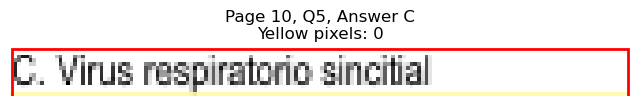

Page 10, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=375.2, y1=392.4
Page 10, Q5, D: Yellow pixels: 1124
Page 10, Q5, D: Total non-white pixels: 1554
Page 10, Q5, D: Yellow percentage: 72.3%


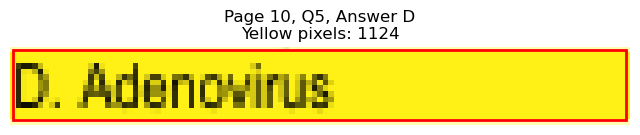


Page 10, Q5 - Selected Answer: D (based on yellow pixel count)
Page 10, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=149.5, y1=430.3
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 473
Page 10, Q6, A: Yellow percentage: 0.0%


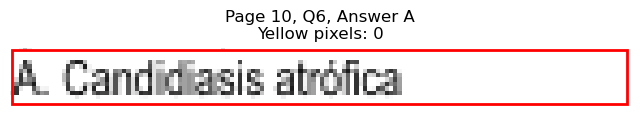

Page 10, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=199.6, y1=442.9
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 703
Page 10, Q6, B: Yellow percentage: 0.0%


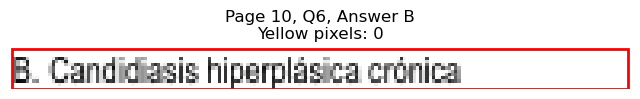

Page 10, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=377.8, y1=430.3
Page 10, Q6, C: Yellow pixels: 1110
Page 10, Q6, C: Total non-white pixels: 1582
Page 10, Q6, C: Yellow percentage: 70.2%


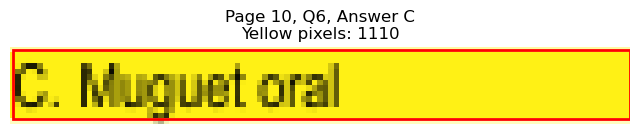

Page 10, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=394.7, y1=442.9
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 537
Page 10, Q6, D: Yellow percentage: 0.0%


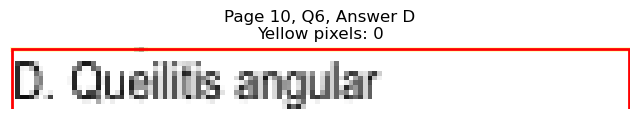


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)
Page 10, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=80.9, y1=493.4
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 86
Page 10, Q7, A: Yellow percentage: 0.0%


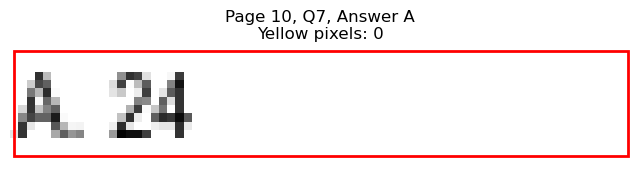

Page 10, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=80.9, y1=506.0
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 87
Page 10, Q7, B: Yellow percentage: 0.0%


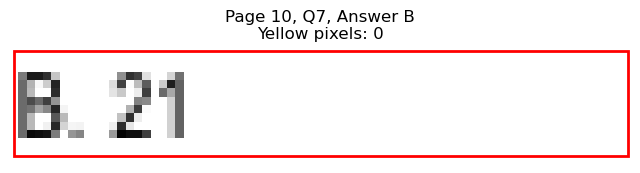

Page 10, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=340.1, y1=493.4
Page 10, Q7, C: Yellow pixels: 847
Page 10, Q7, C: Total non-white pixels: 1064
Page 10, Q7, C: Yellow percentage: 79.6%


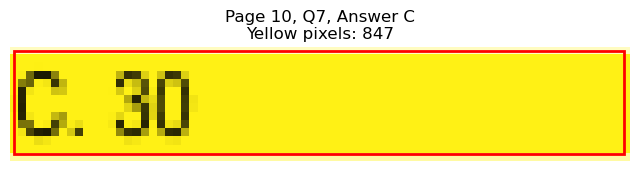

Page 10, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=340.1, y1=506.0
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 162
Page 10, Q7, D: Yellow percentage: 0.0%


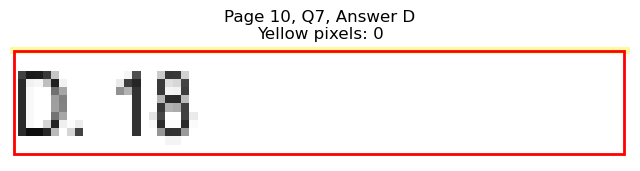


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)
Page 10, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=119.9, y1=556.4
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 285
Page 10, Q8, A: Yellow percentage: 0.0%


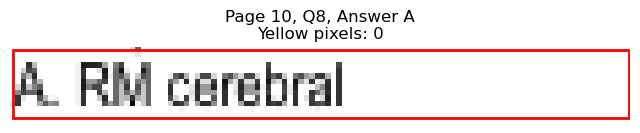

Page 10, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=172.1, y1=569.1
Page 10, Q8, B: Yellow pixels: 1694
Page 10, Q8, B: Total non-white pixels: 2338
Page 10, Q8, B: Yellow percentage: 72.5%


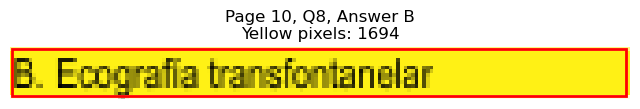

Page 10, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=377.2, y1=556.4
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 273
Page 10, Q8, C: Yellow percentage: 0.0%


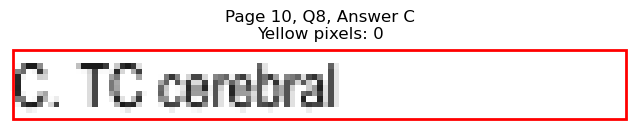

Page 10, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=411.3, y1=569.1
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 465
Page 10, Q8, D: Yellow percentage: 0.0%


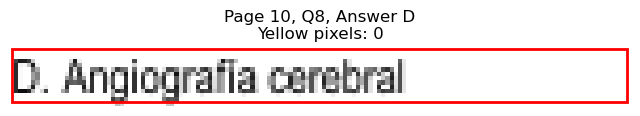


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)
Page 10, Q9 - A: Detected box: x0=56.6, y0=594.3, x1=107.4, y1=606.9
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 228
Page 10, Q9, A: Yellow percentage: 0.0%


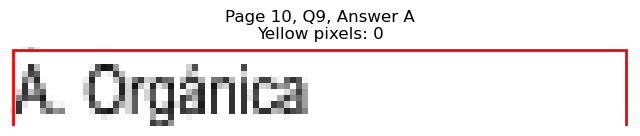

Page 10, Q9 - B: Detected box: x0=56.6, y0=606.9, x1=110.9, y1=619.5
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 252
Page 10, Q9, B: Yellow percentage: 0.0%


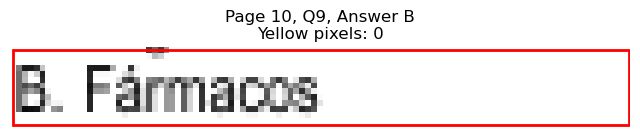

Page 10, Q9 - C: Detected box: x0=315.4, y0=594.3, x1=369.2, y1=606.9
Page 10, Q9, C: Yellow pixels: 1187
Page 10, Q9, C: Total non-white pixels: 1365
Page 10, Q9, C: Yellow percentage: 87.0%


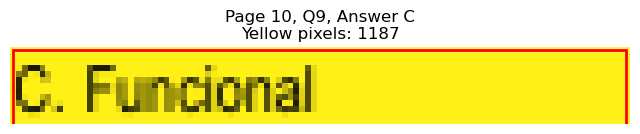

Page 10, Q9 - D: Detected box: x0=315.4, y0=606.9, x1=428.3, y1=619.5
Page 10, Q9, D: Yellow pixels: 164
Page 10, Q9, D: Total non-white pixels: 719
Page 10, Q9, D: Yellow percentage: 22.8%


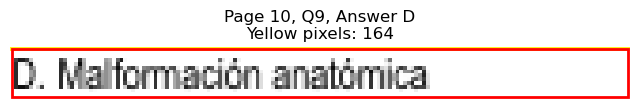


Page 10, Q9 - Selected Answer: C (based on yellow pixel count)
Page 10, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=147.5, y1=682.7
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 374
Page 10, Q10, A: Yellow percentage: 0.0%


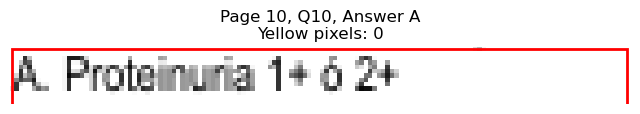

Page 10, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=172.3, y1=695.3
Page 10, Q10, B: Yellow pixels: 0
Page 10, Q10, B: Total non-white pixels: 559
Page 10, Q10, B: Yellow percentage: 0.0%


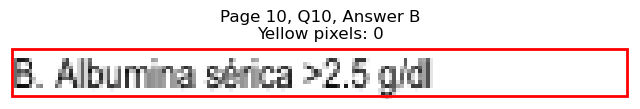

Page 10, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=490.8, y1=682.7
Page 10, Q10, C: Yellow pixels: 2304
Page 10, Q10, C: Total non-white pixels: 2938
Page 10, Q10, C: Yellow percentage: 78.4%


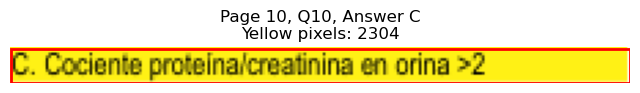

Page 10, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=443.3, y1=695.3
Page 10, Q10, D: Yellow pixels: 179
Page 10, Q10, D: Total non-white pixels: 821
Page 10, Q10, D: Yellow percentage: 21.8%


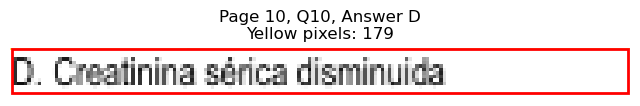


Page 10, Q10 - Selected Answer: C (based on yellow pixel count)
Page 10, Q11 - A: Detected box: x0=56.6, y0=720.6, x1=189.1, y1=733.2
Page 10, Q11, A: Yellow pixels: 1889
Page 10, Q11, A: Total non-white pixels: 2576
Page 10, Q11, A: Yellow percentage: 73.3%


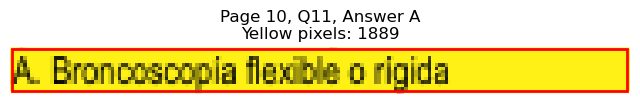

Page 10, Q11 - B: Detected box: x0=56.6, y0=733.2, x1=152.5, y1=745.8
Page 10, Q11, B: Yellow pixels: 0
Page 10, Q11, B: Total non-white pixels: 639
Page 10, Q11, B: Yellow percentage: 0.0%


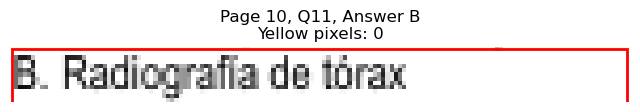

Page 10, Q11 - C: Detected box: x0=315.4, y0=720.6, x1=344.1, y1=733.2
Page 10, Q11, C: Yellow pixels: 0
Page 10, Q11, C: Total non-white pixels: 120
Page 10, Q11, C: Yellow percentage: 0.0%


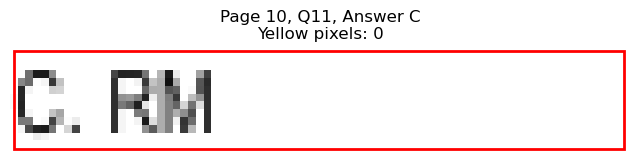

Page 10, Q11 - D: Detected box: x0=315.4, y0=733.2, x1=342.1, y1=745.8
Page 10, Q11, D: Yellow pixels: 0
Page 10, Q11, D: Total non-white pixels: 96
Page 10, Q11, D: Yellow percentage: 0.0%


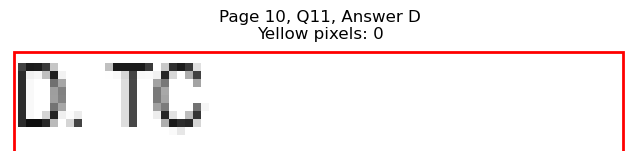


Page 10, Q11 - Selected Answer: A (based on yellow pixel count)

Page 11: Found 6 questions
Page 11, Q1 - A: Detected box: x0=56.6, y0=139.9, x1=147.5, y1=152.6
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 452
Page 11, Q1, A: Yellow percentage: 0.0%


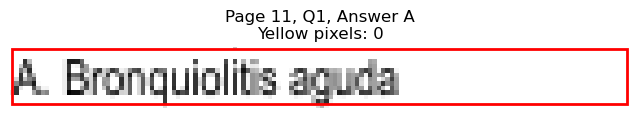

Page 11, Q1 - B: Detected box: x0=56.6, y0=152.5, x1=164.7, y1=165.2
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 543
Page 11, Q1, B: Yellow percentage: 0.0%


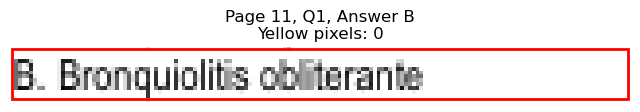

Page 11, Q1 - C: Detected box: x0=315.4, y0=139.9, x1=465.9, y1=152.6
Page 11, Q1, C: Yellow pixels: 2031
Page 11, Q1, C: Total non-white pixels: 2814
Page 11, Q1, C: Yellow percentage: 72.2%


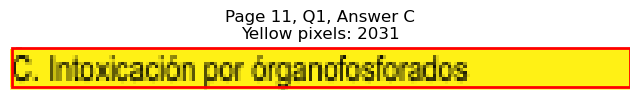

Page 11, Q1 - D: Detected box: x0=315.4, y0=152.5, x1=396.8, y1=165.2
Page 11, Q1, D: Yellow pixels: 131
Page 11, Q1, D: Total non-white pixels: 514
Page 11, Q1, D: Yellow percentage: 25.5%


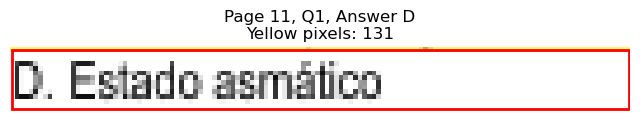


Page 11, Q1 - Selected Answer: C (based on yellow pixel count)
Page 11, Q2 - A: Detected box: x0=56.6, y0=215.6, x1=107.4, y1=228.3
Page 11, Q2, A: Yellow pixels: 102
Page 11, Q2, A: Total non-white pixels: 342
Page 11, Q2, A: Yellow percentage: 29.8%


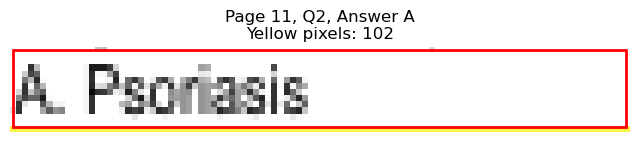

Page 11, Q2 - B: Detected box: x0=56.6, y0=228.2, x1=123.0, y1=240.9
Page 11, Q2, B: Yellow pixels: 1290
Page 11, Q2, B: Total non-white pixels: 1534
Page 11, Q2, B: Yellow percentage: 84.1%


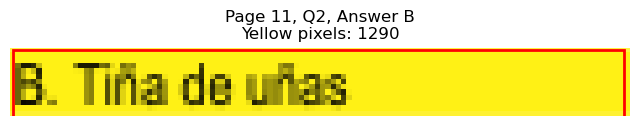

Page 11, Q2 - C: Detected box: x0=315.4, y0=215.6, x1=381.8, y1=228.3
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 288
Page 11, Q2, C: Yellow percentage: 0.0%


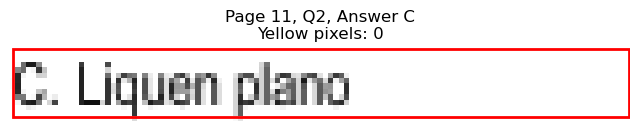

Page 11, Q2 - D: Detected box: x0=315.4, y0=228.2, x1=384.8, y1=240.9
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 344
Page 11, Q2, D: Yellow percentage: 0.0%


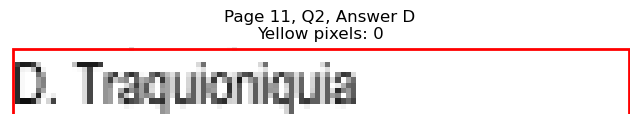


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)
Page 11, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=75.9, y1=291.4
Page 11, Q3, A: Yellow pixels: 855
Page 11, Q3, A: Total non-white pixels: 980
Page 11, Q3, A: Yellow percentage: 87.2%


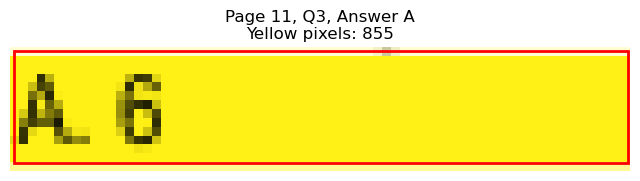

Page 11, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=75.9, y1=304.0
Page 11, Q3, B: Yellow pixels: 70
Page 11, Q3, B: Total non-white pixels: 143
Page 11, Q3, B: Yellow percentage: 49.0%


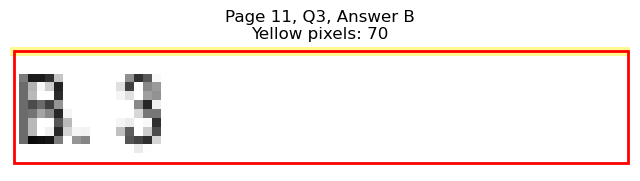

Page 11, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=335.1, y1=291.4
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 71
Page 11, Q3, C: Yellow percentage: 0.0%


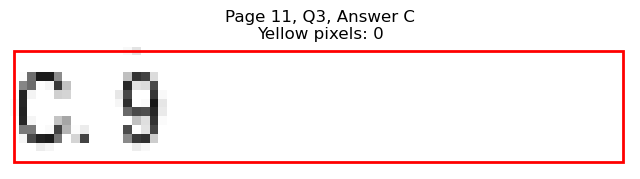

Page 11, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=340.1, y1=304.0
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 79
Page 11, Q3, D: Yellow percentage: 0.0%


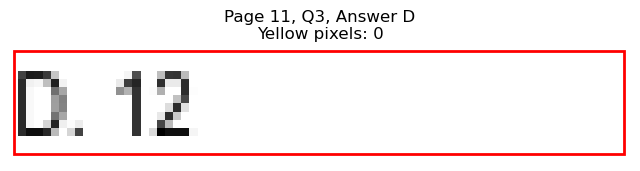


Page 11, Q3 - Selected Answer: A (based on yellow pixel count)
Page 11, Q4 - A: Detected box: x0=56.6, y0=367.1, x1=143.5, y1=379.8
Page 11, Q4, A: Yellow pixels: 1
Page 11, Q4, A: Total non-white pixels: 555
Page 11, Q4, A: Yellow percentage: 0.2%


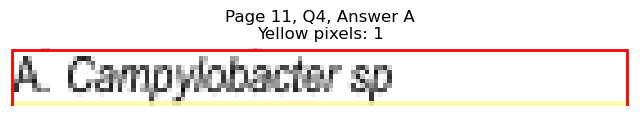

Page 11, Q4 - B: Detected box: x0=56.6, y0=379.7, x1=130.9, y1=392.4
Page 11, Q4, B: Yellow pixels: 1211
Page 11, Q4, B: Total non-white pixels: 1750
Page 11, Q4, B: Yellow percentage: 69.2%


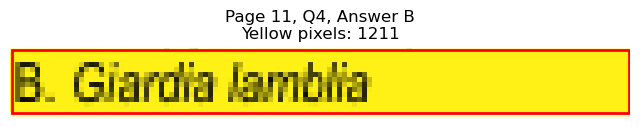

Page 11, Q4 - C: Detected box: x0=315.4, y0=367.1, x1=401.7, y1=379.8
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 433
Page 11, Q4, C: Yellow percentage: 0.0%


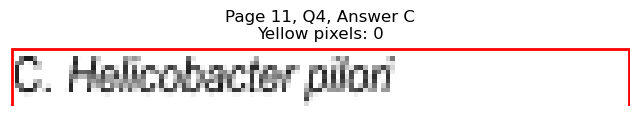

Page 11, Q4 - D: Detected box: x0=315.4, y0=379.7, x1=393.2, y1=392.4
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 383
Page 11, Q4, D: Yellow percentage: 0.0%


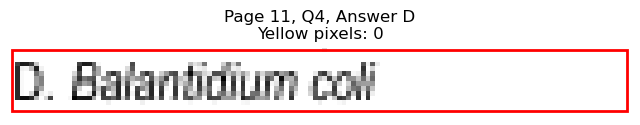


Page 11, Q4 - Selected Answer: B (based on yellow pixel count)
Page 11, Q5 - A: Detected box: x0=56.6, y0=455.5, x1=145.6, y1=468.1
Page 11, Q5, A: Yellow pixels: 140
Page 11, Q5, A: Total non-white pixels: 566
Page 11, Q5, A: Yellow percentage: 24.7%


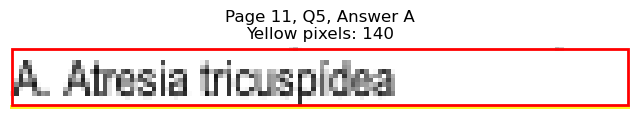

Page 11, Q5 - B: Detected box: x0=56.6, y0=468.1, x1=148.6, y1=480.7
Page 11, Q5, B: Yellow pixels: 1515
Page 11, Q5, B: Total non-white pixels: 1859
Page 11, Q5, B: Yellow percentage: 81.5%


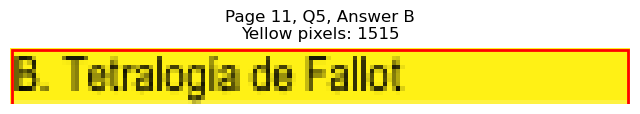

Page 11, Q5 - C: Detected box: x0=315.4, y0=455.5, x1=459.9, y1=468.1
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 706
Page 11, Q5, C: Yellow percentage: 0.0%


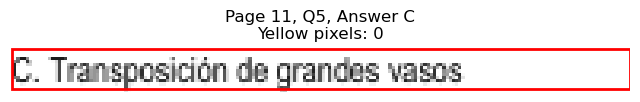

Page 11, Q5 - D: Detected box: x0=315.4, y0=468.1, x1=413.3, y1=480.7
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 460
Page 11, Q5, D: Yellow percentage: 0.0%


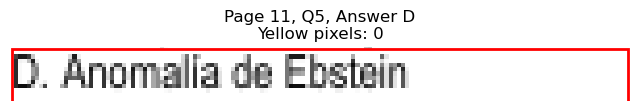


Page 11, Q5 - Selected Answer: B (based on yellow pixel count)
Page 11, Q6 - A: Detected box: x0=56.6, y0=543.8, x1=226.2, y1=556.4
Page 11, Q6, A: Yellow pixels: 2210
Page 11, Q6, A: Total non-white pixels: 3094
Page 11, Q6, A: Yellow percentage: 71.4%


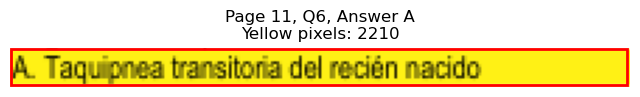

Page 11, Q6 - B: Detected box: x0=56.6, y0=556.5, x1=149.5, y1=569.1
Page 11, Q6, B: Yellow pixels: 144
Page 11, Q6, B: Total non-white pixels: 582
Page 11, Q6, B: Yellow percentage: 24.7%


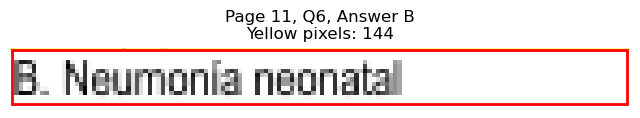

Page 11, Q6 - C: Detected box: x0=315.4, y0=543.8, x1=465.9, y1=556.4
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 704
Page 11, Q6, C: Yellow percentage: 0.0%


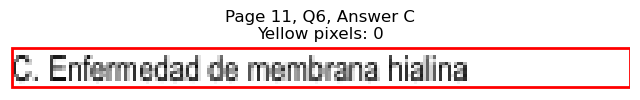

Page 11, Q6 - D: Detected box: x0=315.4, y0=556.5, x1=408.3, y1=569.1
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 471
Page 11, Q6, D: Yellow percentage: 0.0%


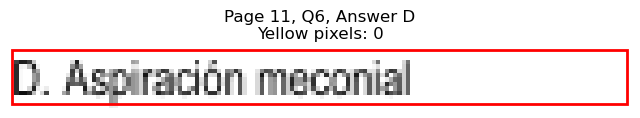


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   La diarrea crónica se define con una duración ...
1   Niño de 5 años, traído al centro de salud por ...
2   Adolescente de 15 años, consulta por fiebre de...
3   En el niño menor de 2 años, que está siendo ev...
4   Niña de 18 meses, hace una semana recibió curs...
..                                                ...
95  Adolescente de 14 años, acude por presentar ca...
96  Ante la confirmación de pubertad precoz y habi...
97  Niño de 5 años con dos semanas de diarrea, dol...
98  Niño de 4 años, presenta intolerancia al esfue...
99  Recién nacido a término de 6 horas, producto d...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                  4/20/200   
1                                 Shiguella   
2               Lupus eritematoso sistémico   
3        Compresión rápida tóraco-abdominal   
4                               Terbinafina   
..                                      ...   
95                                Psoriasis   
96                                        6   
97                         Campylobacter sp   
98                      Atresia tricuspídea   
99  Taquipnea transitoria del recién nacido   

                                       option_B  \
0                                      4/10/200   
1   Escherichia coli productora de toxina Shiga   
2                   Artritis idiopática juvenil   
3                                  Espirometría   
4                                    Tacrolimús   
..                                          ...   
95                                 Tiña de uñas   
96                                            3   
97                              Giardia lamblia   
98                         Tetralogía de Fallot   
99                            Neumonía neonatal   

                            option_C                  option_D  
0                           4/10/300                  4/15/250  
1   Escherichia coli entero invasiva             Campylobacter  
2                           Leucemia                   Linfoma  
3                     Pletismografía  Oscilometría de impulsos  
4                       Betametasona               Clotrimazol  
..                               ...                       ...  
95                      Liquen plano             Traquioniquia  
96                                 9                        12  
97               Helicobacter pilori          Balantidium coli  
98    Transposición de grandes vasos       Anomalía de Ebstein  
99    Enfermedad de membrana hialina       Aspiración meconial  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   La diarrea crónica se define con una duración ...   
1   Niño de 5 años, traído al centro de salud por ...   
2   Adolescente de 15 años, consulta por fiebre de...   
3   En el niño menor de 2 años, que está siendo ev...   
4   Niña de 18 meses, hace una semana recibió curs...   
..                                                ...   
95  Adolescente de 14 años, acude por presentar ca...   
96  Ante la confirmación de pubertad precoz y habi...   
97  Niño de 5 años con dos semanas de diarrea, dol...   
98  Niño de 4 años, presenta intolerancia al esfue...   
99  Recién nacido a término de 6 horas, producto d...   

                                   option_A  \
0                                  4/20/200   
1                                 Shiguella   
2               Lupus eritematoso sistémico   
3        Compresión rápida tóraco-abdominal   
4                               Terbinafina   
..                                      ...   
95                                Psoriasis   
96                                        6   
97                         Campylobacter sp   
98                      Atresia tricuspídea   
99  Taquipnea transitoria del recién nacido   

                                       option_B  \
0                                      4/10/200   
1   Escherichia coli productora de toxina Shiga   
2                   Artritis idiopática juvenil   
3                                  Espirometría   
4                                    Tacrolimús   
..                                          ...   
95                                 Tiña de uñas   
96                                            3   
97                              Giardia lamblia   
98                         Tetralogía de Fallot   
99                            Neumonía neonatal   

                            option_C                  option_D correct_answer  
0                           4/10/300                  4/15/250              B  
1   Escherichia coli entero invasiva             Campylobacter              B  
2                           Leucemia                   Linfoma              A  
3                     Pletismografía  Oscilometría de impulsos              A  
4                       Betametasona               Clotrimazol              D  
..                               ...                       ...            ...  
95                      Liquen plano             Traquioniquia              B  
96                                 9                        12              A  
97               Helicobacter pilori          Balantidium coli              B  
98    Transposición de grandes vasos       Anomalía de Ebstein              B  
99    Enfermedad de membrana hialina       Aspiración meconial              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/PEDIATRÍA.csv
